In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

First, let's plot up a basic orbit with *exoplanet* to see if the best-fit parameters from Pourbaix et al. make sense. With the addition of radial velocity data, we can now constrain the masses of the stars. 

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_km = constants.au.to(u.km).value
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# we parameterize exoplanet in terms of M2, so we'll need to 
# calculate Mtot from a, P, then M2 from Mtot and kappa
Mtot = calc_Mtot(a, P)
M2 = kappa * Mtot


# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
# note that we now include M2 in the KeplerianOrbit initialization
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - 0.5 * P, T0 + 0.5 * P, num=2000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

It looks like a pretty good starting point. So, let's set up the model in PyMC3 for sampling.

In [12]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

# for predicted sky orbits, spanning a full period
t_sky = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    M2 = pm.Normal("M2", mu=1.0, sd=0.5) # solar masses
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    M1 = pm.Deterministic("M1", Mtot - M2)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
    # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
    # this is handled naturally by exoplanets get_radial_velocity (of the star), but since we also want
    # the "planet" velocity, or the velocity of the secondary, we queried both in this manner to be consistent
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future sep, pa, and RV plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)
    
    # sky plots
    t_period = pm.Deterministic("tPeriod", t_sky * P + t_periastron)
    
    # save some samples on a fine orbit for sky plotting purposes
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)

In [13]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Desired error not necessarily achieved due to precision loss.
logp: -181.75633483899398 -> 171.06970010730316


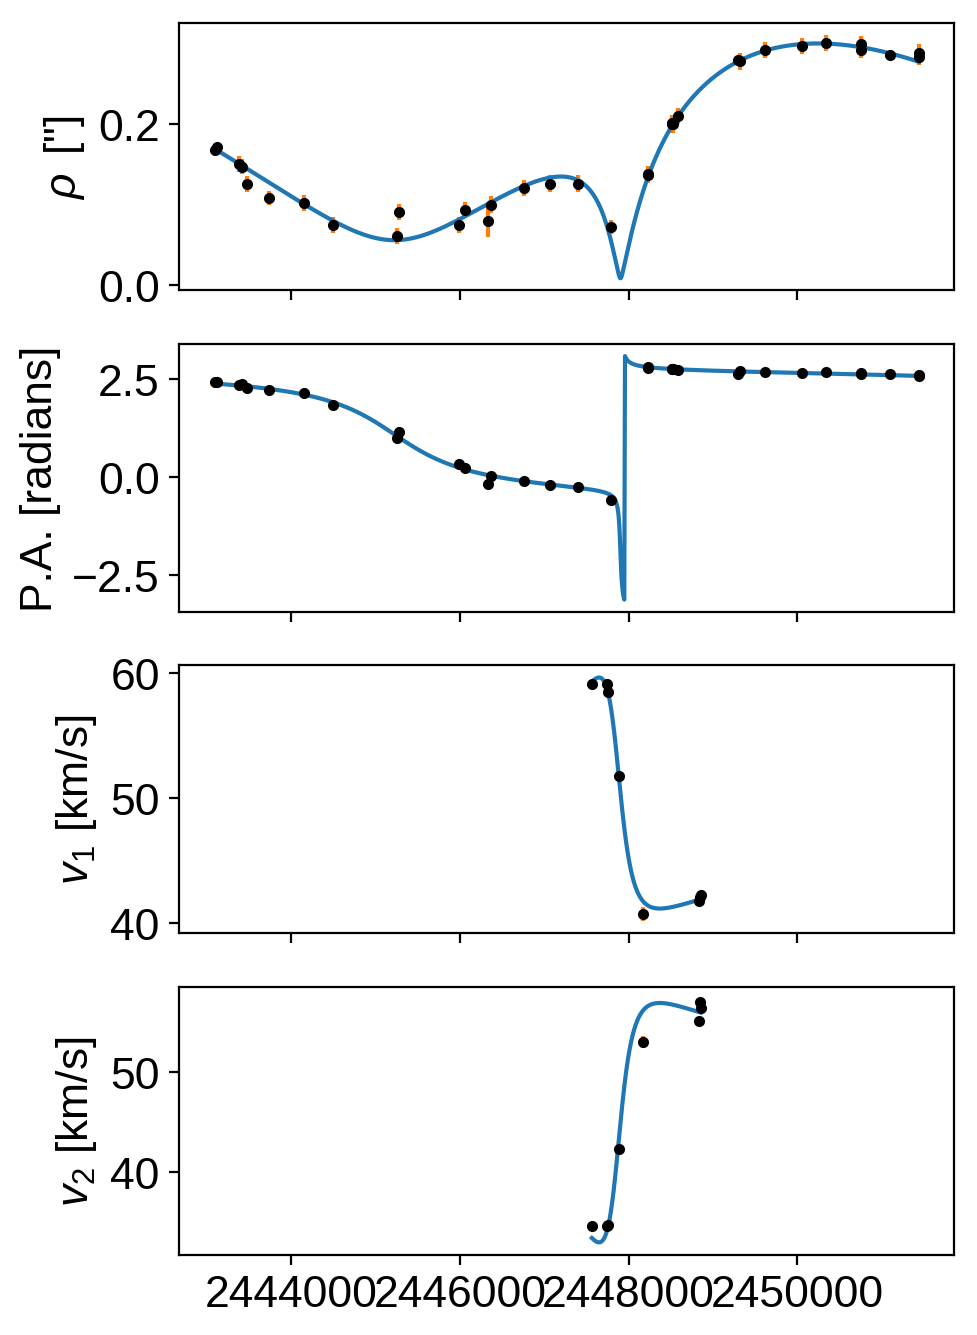

In [14]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [15]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:08, 98.80draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:11, 67.14draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:15, 52.18draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:16, 47.14draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:17, 44.20draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:18, 42.36draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:18, 41.17draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:19, 40.36draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:19, 39.81draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:19, 39.43draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:19, 39.17draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:19, 38.98draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:19, 38.85draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:19, 38.75draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:19, 37.92draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:19, 37.53draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:19, 37.28draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:19, 37.13draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:02<00:19, 37.00draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:19, 36.11draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:19, 36.25draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:19, 36.37draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:19, 36.48draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:19, 36.82draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:18, 36.97draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:18, 37.24draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:02<00:18, 37.43draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:03<00:18, 37.57draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:18, 37.65draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:03<00:18, 37.23draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:03<00:18, 37.42draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:03<00:18, 37.12draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:03<00:17, 37.21draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:03<00:17, 37.19draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:03<00:17, 37.39draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:17, 37.56draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:03<00:17, 37.67draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:04<00:17, 37.76draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:04<00:17, 37.81draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:16, 37.84draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:04<00:16, 37.69draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:04<00:16, 37.76draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:04<00:16, 37.77draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:04<00:16, 38.40draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:04<00:16, 37.92draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:04<00:16, 37.73draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:05<00:16, 37.80draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:05<00:16, 37.84draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:05<00:15, 37.86draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:05<00:15, 37.88draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:05<00:15, 37.87draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:05<00:15, 37.87draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:05<00:15, 37.87draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:05<00:15, 37.88draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:05<00:15, 37.42draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:05<00:15, 37.55draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:06<00:15, 37.66draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:06<00:15, 37.74draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:06<00:14, 37.81draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:06<00:14, 37.85draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:06<00:14, 37.63draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:06<00:14, 37.71draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:06<00:14, 37.77draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:06<00:14, 37.83draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:06<00:14, 37.87draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:07<00:14, 37.92draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:07<00:13, 37.96draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:07<00:13, 37.98draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:07<00:13, 37.87draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:07<00:13, 37.87draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:07<00:13, 37.89draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:07<00:13, 37.91draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:07<00:13, 37.35draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:07<00:13, 37.51draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:07<00:13, 37.66draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:08<00:13, 37.75draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:08<00:13, 37.69draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:08<00:12, 37.63draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:08<00:12, 37.55draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:08<00:12, 37.46draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:08<00:12, 37.29draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:08<00:12, 36.69draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:08<00:12, 37.00draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:08<00:12, 37.21draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:09<00:12, 37.45draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:09<00:12, 37.58draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:09<00:11, 37.72draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:09<00:11, 37.86draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:09<00:11, 37.91draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:09<00:11, 37.98draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:09<00:11, 38.18draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:09<00:11, 38.32draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:09<00:11, 38.43draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:10<00:10, 38.51draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:10<00:10, 38.54draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:10<00:10, 38.36draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:10<00:10, 38.34draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:10<00:10, 38.42draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:10<00:10, 38.36draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:10<00:10, 38.27draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:10<00:10, 38.20draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:10<00:09, 40.59draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:10<00:09, 41.00draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [00:11<00:10, 37.13draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:11<00:10, 37.59draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:11<00:09, 37.92draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:11<00:09, 38.16draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:11<00:09, 38.32draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [00:11<00:09, 38.43draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:11<00:09, 38.52draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [00:11<00:09, 38.58draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:11<00:09, 38.64draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:12<00:08, 38.64draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:12<00:08, 38.64draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:12<00:08, 38.64draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:12<00:08, 38.65draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:12<00:08, 38.65draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:12<00:08, 38.61draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:12<00:08, 38.64draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:12<00:08, 38.67draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [00:12<00:08, 38.68draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:12<00:07, 38.62draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:13<00:07, 38.39draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:13<00:07, 37.93draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:13<00:07, 37.56draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:13<00:07, 37.36draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:13<00:07, 37.21draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:13<00:07, 37.12draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:13<00:07, 37.05draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:13<00:07, 37.02draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:13<00:07, 36.98draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:14<00:07, 36.96draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [00:14<00:07, 36.95draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:14<00:07, 36.93draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:14<00:06, 36.92draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:14<00:06, 36.93draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:14<00:06, 36.92draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [00:14<00:06, 36.91draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:14<00:06, 36.90draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:14<00:06, 36.89draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:15<00:06, 36.88draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:15<00:06, 36.90draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:15<00:06, 36.90draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:15<00:05, 37.05draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [00:15<00:05, 37.53draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:15<00:05, 37.87draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:15<00:05, 38.08draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:15<00:05, 37.92draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:15<00:05, 38.14draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:15<00:05, 38.32draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:16<00:04, 38.45draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:16<00:04, 38.54draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [00:16<00:04, 38.58draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:16<00:04, 38.63draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:16<00:04, 38.65draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:16<00:04, 38.66draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:16<00:04, 38.68draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:16<00:04, 38.71draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:16<00:04, 38.68draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:17<00:04, 38.71draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:17<00:03, 38.74draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:17<00:03, 38.76draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:17<00:03, 38.71draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:17<00:03, 38.45draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:17<00:03, 37.97draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [00:17<00:03, 37.61draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:17<00:03, 37.39draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:17<00:03, 37.23draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:17<00:03, 37.14draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:18<00:03, 37.07draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:18<00:03, 37.03draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:18<00:02, 36.91draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:18<00:02, 36.91draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [00:18<00:02, 36.89draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:18<00:02, 36.88draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:18<00:02, 37.06draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:18<00:02, 37.35draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:18<00:02, 37.55draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:19<00:02, 37.70draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:19<00:02, 37.81draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:19<00:01, 37.90draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:19<00:01, 37.94draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:19<00:01, 37.98draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:19<00:01, 38.02draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:19<00:01, 38.05draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:19<00:01, 38.07draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:19<00:01, 38.07draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:20<00:01, 37.13draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:20<00:01, 37.38draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:20<00:00, 37.60draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:20<00:00, 37.75draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:20<00:00, 40.26draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:20<00:00, 41.60draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:20<00:00, 35.51draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:20<00:00, 34.85draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:21<00:00, 28.19draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:21<00:00, 23.70draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:21<00:00, 13.95draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:22<00:00, 36.45draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:03, 120.55draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 68.11draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:07, 52.91draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:08, 46.46draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:08, 42.95draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:09, 41.05draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:00<00:08, 42.50draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:00<00:07, 45.75draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:01<00:07, 45.67draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:01<00:07, 43.82draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:01<00:07, 43.90draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:01<00:07, 46.58draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:01<00:07, 46.22draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:07, 44.54draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:01<00:08, 39.44draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:01<00:07, 43.67draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:01<00:07, 44.25draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:02<00:07, 39.42draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:02<00:07, 41.15draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:02<00:06, 44.32draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:06, 44.42draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:02<00:07, 40.77draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:02<00:06, 44.45draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:02<00:06, 45.11draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:02<00:05, 45.15draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:03<00:06, 42.32draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:03<00:06, 40.44draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:03<00:06, 40.54draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:03<00:05, 42.23draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:03<00:05, 43.31draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:03<00:05, 43.36draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:03<00:05, 44.38draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:03<00:05, 44.40draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:04<00:05, 37.68draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:04<00:05, 42.58draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:04<00:05, 41.25draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:04<00:05, 40.54draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:04<00:04, 44.03draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:04<00:04, 39.91draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:04<00:04, 39.99draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:04<00:04, 42.44draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:05<00:04, 42.39draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:05<00:04, 42.53draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:05<00:03, 43.78draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:05<00:03, 44.21draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:05<00:03, 41.64draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:05<00:03, 42.19draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:05<00:03, 42.33draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:05<00:03, 43.90draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:06<00:03, 42.82draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:06<00:03, 40.43draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:06<00:03, 41.80draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:06<00:02, 42.55draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:06<00:02, 43.37draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:06<00:02, 44.09draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:06<00:02, 44.58draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:06<00:02, 44.50draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:06<00:02, 44.43draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:07<00:02, 44.91draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:07<00:02, 44.96draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:07<00:02, 38.13draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:07<00:02, 39.68draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:07<00:01, 41.36draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:07<00:01, 41.87draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:07<00:01, 43.02draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:07<00:01, 41.25draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:08<00:01, 42.58draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:08<00:01, 43.52draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:08<00:01, 42.71draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:08<00:01, 40.34draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:08<00:00, 41.32draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:08<00:00, 39.46draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:08<00:00, 41.52draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:08<00:00, 41.51draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:08<00:00, 42.76draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:09<00:00, 43.65draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:09<00:00, 34.70draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:09<00:00, 29.21draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 41.37draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:04, 164.77draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:04, 179.82draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:00<00:03, 211.16draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:00<00:02, 235.61draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:00<00:02, 262.94draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:00<00:02, 287.38draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:00<00:02, 295.02draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:00<00:01, 313.50draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:00<00:01, 330.77draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:01<00:01, 338.72draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:01<00:01, 333.40draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:01<00:01, 330.12draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:01<00:01, 315.91draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:01<00:01, 313.02draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [00:01<00:00, 319.77draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:01<00:00, 328.38draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:01<00:00, 304.62draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:01<00:00, 308.28draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:01<00:00, 322.91draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:02<00:00, 324.88draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:02<00:00, 320.13draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:02<00:00, 299.59draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [00:02<00:00, 273.58draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:02<00:00, 223.68draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 286.18draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:00<00:08, 178.50draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:00<00:09, 171.17draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:00<00:09, 163.87draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:00<00:08, 174.21draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:00<00:08, 170.38draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:00<00:10, 148.31draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:00<00:09, 153.72draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:00<00:08, 165.29draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:00<00:08, 172.99draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:01<00:08, 170.27draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:01<00:08, 167.95draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:01<00:08, 159.43draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:01<00:08, 166.98draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:01<00:08, 164.60draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:01<00:08, 156.07draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:01<00:08, 149.27draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:01<00:08, 150.08draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:01<00:08, 157.70draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:02<00:07, 160.66draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:02<00:07, 171.82draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:02<00:07, 160.81draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:02<00:07, 161.90draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:02<00:07, 166.21draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:02<00:07, 167.25draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:02<00:06, 183.83draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:02<00:06, 181.64draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [00:02<00:06, 179.78draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:03<00:05, 189.12draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:03<00:05, 209.99draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:03<00:04, 219.04draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [00:03<00:04, 218.65draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [00:03<00:04, 231.28draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:03<00:04, 237.84draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [00:03<00:03, 248.33draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [00:03<00:04, 220.36draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:03<00:04, 209.49draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:04<00:04, 212.96draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:04<00:03, 220.33draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [00:04<00:03, 219.22draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [00:04<00:03, 222.97draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [00:04<00:03, 232.71draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [00:04<00:03, 221.92draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [00:04<00:03, 214.09draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [00:04<00:03, 204.53draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:04<00:03, 201.49draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [00:05<00:03, 201.69draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [00:05<00:03, 193.88draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [00:05<00:03, 202.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [00:05<00:02, 206.61draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [00:05<00:02, 215.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [00:05<00:02, 227.96draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [00:05<00:02, 247.45draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:05<00:01, 245.56draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [00:05<00:02, 195.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [00:06<00:02, 181.77draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [00:06<00:02, 178.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [00:06<00:02, 171.25draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [00:06<00:02, 182.31draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [00:06<00:01, 193.82draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [00:06<00:01, 204.66draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [00:06<00:01, 219.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [00:06<00:01, 222.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [00:06<00:01, 236.83draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [00:07<00:00, 221.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [00:07<00:00, 216.85draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [00:07<00:00, 214.39draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [00:07<00:00, 208.58draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [00:07<00:00, 206.60draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [00:07<00:00, 192.75draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [00:07<00:00, 168.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [00:07<00:00, 138.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [00:08<00:00, 121.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [00:08<00:00, 124.73draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [00:08<00:00, 120.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [00:08<00:00, 93.94draws/s] 

Sampling 4 chains: 100%|█████████▉| 1607/1608 [00:08<00:00, 80.51draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:08<00:00, 182.38draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<00:17, 186.46draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:00<00:16, 187.19draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:00<00:17, 183.53draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:00<00:16, 190.56draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:00<00:15, 204.95draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:00<00:14, 211.33draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:00<00:17, 177.79draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:00<00:17, 174.47draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:00<00:16, 185.00draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:01<00:14, 201.24draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:01<00:14, 199.93draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:01<00:15, 196.28draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:01<00:14, 200.79draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:01<00:14, 199.34draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:01<00:14, 199.93draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:01<00:14, 201.82draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:01<00:14, 198.69draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [00:01<00:14, 199.25draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:02<00:14, 199.95draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:02<00:12, 213.64draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:02<00:11, 229.99draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [00:02<00:11, 245.82draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:02<00:11, 227.33draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [00:02<00:12, 219.26draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:02<00:11, 233.55draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [00:02<00:10, 239.24draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [00:02<00:10, 250.12draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [00:03<00:10, 251.76draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [00:03<00:09, 257.87draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [00:03<00:09, 262.73draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [00:03<00:09, 269.63draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [00:03<00:09, 260.05draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:03<00:09, 257.18draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [00:03<00:08, 268.65draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [00:03<00:08, 269.43draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:03<00:08, 259.92draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:03<00:09, 250.25draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [00:04<00:09, 250.53draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [00:04<00:08, 260.01draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [00:04<00:08, 260.06draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [00:04<00:08, 263.66draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [00:04<00:07, 279.59draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [00:04<00:07, 269.93draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [00:04<00:08, 246.35draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [00:04<00:08, 251.03draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [00:04<00:08, 255.22draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [00:05<00:07, 262.58draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [00:05<00:08, 244.44draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [00:05<00:08, 243.92draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [00:05<00:08, 242.50draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [00:05<00:07, 247.54draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [00:05<00:07, 247.70draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [00:05<00:07, 244.74draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [00:05<00:07, 242.41draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [00:05<00:07, 249.90draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [00:06<00:07, 248.31draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [00:06<00:07, 248.95draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [00:06<00:07, 246.56draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [00:06<00:07, 232.19draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [00:06<00:07, 231.33draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [00:06<00:06, 240.71draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [00:06<00:06, 250.86draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [00:06<00:06, 250.16draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [00:06<00:06, 239.83draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [00:06<00:06, 236.84draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [00:07<00:06, 239.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [00:07<00:06, 241.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [00:07<00:05, 249.14draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [00:07<00:05, 258.64draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [00:07<00:05, 264.10draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [00:07<00:05, 264.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [00:07<00:04, 283.16draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [00:07<00:04, 294.96draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [00:07<00:04, 283.32draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [00:08<00:04, 270.04draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [00:08<00:04, 267.03draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [00:08<00:04, 279.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [00:08<00:04, 288.05draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [00:08<00:04, 281.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [00:08<00:04, 275.91draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [00:08<00:04, 270.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [00:08<00:04, 261.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [00:08<00:03, 263.15draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [00:09<00:03, 259.30draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [00:09<00:03, 274.24draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [00:09<00:03, 271.24draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [00:09<00:03, 268.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [00:09<00:03, 271.82draws/s]

Sampling 4 chains:  73%|███████▎  | 2349/3208 [00:09<00:03, 276.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [00:09<00:03, 266.01draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [00:09<00:03, 256.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [00:09<00:02, 262.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [00:09<00:02, 259.09draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [00:10<00:02, 260.62draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [00:10<00:02, 272.22draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [00:10<00:02, 274.40draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [00:10<00:02, 274.07draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [00:10<00:02, 281.97draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [00:10<00:02, 276.85draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [00:10<00:01, 279.37draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [00:10<00:01, 274.53draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [00:10<00:01, 269.11draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [00:11<00:01, 272.75draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [00:11<00:01, 289.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [00:11<00:01, 284.54draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [00:11<00:01, 280.36draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [00:11<00:01, 281.47draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [00:11<00:01, 271.03draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [00:11<00:01, 274.56draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [00:11<00:00, 262.77draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [00:11<00:00, 260.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [00:11<00:00, 258.13draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [00:12<00:00, 256.66draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [00:12<00:00, 265.30draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [00:12<00:00, 266.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [00:12<00:00, 265.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [00:12<00:00, 252.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [00:12<00:00, 217.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [00:13<00:00, 119.29draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:13<00:00, 241.40draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 17/9208 [00:00<00:56, 162.68draws/s]

Sampling 4 chains:   0%|          | 35/9208 [00:00<00:54, 167.11draws/s]

Sampling 4 chains:   1%|          | 50/9208 [00:00<00:57, 160.08draws/s]

Sampling 4 chains:   1%|          | 65/9208 [00:00<00:59, 153.83draws/s]

Sampling 4 chains:   1%|          | 87/9208 [00:00<00:54, 166.51draws/s]

Sampling 4 chains:   1%|          | 108/9208 [00:00<00:51, 175.23draws/s]

Sampling 4 chains:   1%|▏         | 134/9208 [00:00<00:46, 193.57draws/s]

Sampling 4 chains:   2%|▏         | 157/9208 [00:00<00:44, 202.57draws/s]

Sampling 4 chains:   2%|▏         | 178/9208 [00:00<00:45, 197.78draws/s]

Sampling 4 chains:   2%|▏         | 201/9208 [00:01<00:43, 206.11draws/s]

Sampling 4 chains:   2%|▏         | 223/9208 [00:01<00:43, 207.17draws/s]

Sampling 4 chains:   3%|▎         | 244/9208 [00:01<00:43, 205.04draws/s]

Sampling 4 chains:   3%|▎         | 270/9208 [00:01<00:40, 218.01draws/s]

Sampling 4 chains:   3%|▎         | 298/9208 [00:01<00:38, 230.14draws/s]

Sampling 4 chains:   4%|▎         | 324/9208 [00:01<00:37, 234.88draws/s]

Sampling 4 chains:   4%|▍         | 348/9208 [00:01<00:39, 223.95draws/s]

Sampling 4 chains:   4%|▍         | 376/9208 [00:01<00:37, 237.69draws/s]

Sampling 4 chains:   4%|▍         | 404/9208 [00:01<00:35, 248.63draws/s]

Sampling 4 chains:   5%|▍         | 430/9208 [00:02<00:36, 239.42draws/s]

Sampling 4 chains:   5%|▍         | 455/9208 [00:02<00:38, 229.44draws/s]

Sampling 4 chains:   5%|▌         | 479/9208 [00:02<00:40, 215.84draws/s]

Sampling 4 chains:   5%|▌         | 502/9208 [00:02<00:39, 218.82draws/s]

Sampling 4 chains:   6%|▌         | 525/9208 [00:02<00:39, 217.35draws/s]

Sampling 4 chains:   6%|▌         | 551/9208 [00:02<00:39, 221.95draws/s]

Sampling 4 chains:   6%|▋         | 581/9208 [00:02<00:35, 240.08draws/s]

Sampling 4 chains:   7%|▋         | 606/9208 [00:02<00:35, 242.04draws/s]

Sampling 4 chains:   7%|▋         | 632/9208 [00:02<00:34, 246.12draws/s]

Sampling 4 chains:   7%|▋         | 657/9208 [00:02<00:35, 243.78draws/s]

Sampling 4 chains:   7%|▋         | 682/9208 [00:03<00:36, 233.86draws/s]

Sampling 4 chains:   8%|▊         | 706/9208 [00:03<00:36, 232.09draws/s]

Sampling 4 chains:   8%|▊         | 734/9208 [00:03<00:34, 243.56draws/s]

Sampling 4 chains:   8%|▊         | 759/9208 [00:03<00:34, 244.79draws/s]

Sampling 4 chains:   9%|▊         | 784/9208 [00:03<00:34, 244.65draws/s]

Sampling 4 chains:   9%|▉         | 812/9208 [00:03<00:33, 250.72draws/s]

Sampling 4 chains:   9%|▉         | 839/9208 [00:03<00:33, 253.28draws/s]

Sampling 4 chains:   9%|▉         | 865/9208 [00:03<00:33, 251.09draws/s]

Sampling 4 chains:  10%|▉         | 894/9208 [00:03<00:32, 256.59draws/s]

Sampling 4 chains:  10%|▉         | 920/9208 [00:04<00:33, 250.48draws/s]

Sampling 4 chains:  10%|█         | 951/9208 [00:04<00:31, 264.99draws/s]

Sampling 4 chains:  11%|█         | 980/9208 [00:04<00:30, 271.20draws/s]

Sampling 4 chains:  11%|█         | 1008/9208 [00:04<00:33, 246.04draws/s]

Sampling 4 chains:  11%|█         | 1034/9208 [00:04<00:34, 239.34draws/s]

Sampling 4 chains:  12%|█▏        | 1062/9208 [00:04<00:32, 248.36draws/s]

Sampling 4 chains:  12%|█▏        | 1088/9208 [00:04<00:32, 249.04draws/s]

Sampling 4 chains:  12%|█▏        | 1114/9208 [00:04<00:33, 244.82draws/s]

Sampling 4 chains:  12%|█▏        | 1139/9208 [00:04<00:33, 243.53draws/s]

Sampling 4 chains:  13%|█▎        | 1167/9208 [00:05<00:31, 252.12draws/s]

Sampling 4 chains:  13%|█▎        | 1193/9208 [00:05<00:32, 247.33draws/s]

Sampling 4 chains:  13%|█▎        | 1218/9208 [00:05<00:32, 245.35draws/s]

Sampling 4 chains:  14%|█▎        | 1247/9208 [00:05<00:31, 255.85draws/s]

Sampling 4 chains:  14%|█▍        | 1276/9208 [00:05<00:30, 263.26draws/s]

Sampling 4 chains:  14%|█▍        | 1307/9208 [00:05<00:28, 273.07draws/s]

Sampling 4 chains:  15%|█▍        | 1337/9208 [00:05<00:28, 279.15draws/s]

Sampling 4 chains:  15%|█▍        | 1366/9208 [00:05<00:29, 270.21draws/s]

Sampling 4 chains:  15%|█▌        | 1394/9208 [00:05<00:29, 269.05draws/s]

Sampling 4 chains:  15%|█▌        | 1423/9208 [00:05<00:28, 273.78draws/s]

Sampling 4 chains:  16%|█▌        | 1458/9208 [00:06<00:26, 292.00draws/s]

Sampling 4 chains:  16%|█▌        | 1488/9208 [00:06<00:26, 292.54draws/s]

Sampling 4 chains:  16%|█▋        | 1518/9208 [00:06<00:27, 276.71draws/s]

Sampling 4 chains:  17%|█▋        | 1547/9208 [00:06<00:29, 263.54draws/s]

Sampling 4 chains:  17%|█▋        | 1575/9208 [00:06<00:28, 267.00draws/s]

Sampling 4 chains:  17%|█▋        | 1603/9208 [00:06<00:28, 269.63draws/s]

Sampling 4 chains:  18%|█▊        | 1634/9208 [00:06<00:27, 276.47draws/s]

Sampling 4 chains:  18%|█▊        | 1662/9208 [00:06<00:28, 262.53draws/s]

Sampling 4 chains:  18%|█▊        | 1689/9208 [00:06<00:28, 259.73draws/s]

Sampling 4 chains:  19%|█▊        | 1720/9208 [00:07<00:27, 269.46draws/s]

Sampling 4 chains:  19%|█▉        | 1748/9208 [00:07<00:28, 264.89draws/s]

Sampling 4 chains:  19%|█▉        | 1776/9208 [00:07<00:27, 266.81draws/s]

Sampling 4 chains:  20%|█▉        | 1806/9208 [00:07<00:27, 272.38draws/s]

Sampling 4 chains:  20%|█▉        | 1836/9208 [00:07<00:26, 278.68draws/s]

Sampling 4 chains:  20%|██        | 1864/9208 [00:07<00:26, 275.40draws/s]

Sampling 4 chains:  21%|██        | 1893/9208 [00:07<00:26, 278.17draws/s]

Sampling 4 chains:  21%|██        | 1921/9208 [00:07<00:26, 273.78draws/s]

Sampling 4 chains:  21%|██        | 1949/9208 [00:07<00:26, 272.88draws/s]

Sampling 4 chains:  21%|██▏       | 1977/9208 [00:07<00:27, 263.47draws/s]

Sampling 4 chains:  22%|██▏       | 2004/9208 [00:08<00:27, 263.45draws/s]

Sampling 4 chains:  22%|██▏       | 2031/9208 [00:08<00:28, 252.69draws/s]

Sampling 4 chains:  22%|██▏       | 2057/9208 [00:08<00:28, 249.08draws/s]

Sampling 4 chains:  23%|██▎       | 2084/9208 [00:08<00:27, 255.00draws/s]

Sampling 4 chains:  23%|██▎       | 2110/9208 [00:08<00:28, 249.13draws/s]

Sampling 4 chains:  23%|██▎       | 2137/9208 [00:08<00:27, 253.19draws/s]

Sampling 4 chains:  23%|██▎       | 2163/9208 [00:08<00:28, 245.52draws/s]

Sampling 4 chains:  24%|██▍       | 2191/9208 [00:08<00:27, 253.73draws/s]

Sampling 4 chains:  24%|██▍       | 2220/9208 [00:08<00:26, 259.56draws/s]

Sampling 4 chains:  24%|██▍       | 2247/9208 [00:09<00:27, 257.39draws/s]

Sampling 4 chains:  25%|██▍       | 2273/9208 [00:09<00:28, 247.36draws/s]

Sampling 4 chains:  25%|██▍       | 2299/9208 [00:09<00:27, 249.61draws/s]

Sampling 4 chains:  25%|██▌       | 2327/9208 [00:09<00:26, 257.93draws/s]

Sampling 4 chains:  26%|██▌       | 2353/9208 [00:09<00:26, 257.78draws/s]

Sampling 4 chains:  26%|██▌       | 2384/9208 [00:09<00:25, 270.13draws/s]

Sampling 4 chains:  26%|██▌       | 2412/9208 [00:09<00:24, 273.01draws/s]

Sampling 4 chains:  27%|██▋       | 2444/9208 [00:09<00:23, 284.42draws/s]

Sampling 4 chains:  27%|██▋       | 2473/9208 [00:09<00:24, 279.77draws/s]

Sampling 4 chains:  27%|██▋       | 2502/9208 [00:10<00:24, 268.25draws/s]

Sampling 4 chains:  27%|██▋       | 2530/9208 [00:10<00:25, 266.94draws/s]

Sampling 4 chains:  28%|██▊       | 2558/9208 [00:10<00:24, 268.84draws/s]

Sampling 4 chains:  28%|██▊       | 2587/9208 [00:10<00:24, 271.44draws/s]

Sampling 4 chains:  28%|██▊       | 2615/9208 [00:10<00:24, 271.30draws/s]

Sampling 4 chains:  29%|██▊       | 2643/9208 [00:10<00:24, 273.40draws/s]

Sampling 4 chains:  29%|██▉       | 2671/9208 [00:10<00:24, 269.04draws/s]

Sampling 4 chains:  29%|██▉       | 2698/9208 [00:10<00:24, 268.49draws/s]

Sampling 4 chains:  30%|██▉       | 2725/9208 [00:10<00:24, 267.62draws/s]

Sampling 4 chains:  30%|██▉       | 2755/9208 [00:10<00:23, 276.21draws/s]

Sampling 4 chains:  30%|███       | 2783/9208 [00:11<00:23, 276.02draws/s]

Sampling 4 chains:  31%|███       | 2811/9208 [00:11<00:23, 270.97draws/s]

Sampling 4 chains:  31%|███       | 2840/9208 [00:11<00:23, 273.34draws/s]

Sampling 4 chains:  31%|███       | 2868/9208 [00:11<00:23, 274.39draws/s]

Sampling 4 chains:  31%|███▏      | 2896/9208 [00:11<00:23, 273.76draws/s]

Sampling 4 chains:  32%|███▏      | 2925/9208 [00:11<00:22, 276.63draws/s]

Sampling 4 chains:  32%|███▏      | 2953/9208 [00:11<00:23, 268.63draws/s]

Sampling 4 chains:  32%|███▏      | 2981/9208 [00:11<00:22, 271.04draws/s]

Sampling 4 chains:  33%|███▎      | 3009/9208 [00:11<00:22, 273.51draws/s]

Sampling 4 chains:  33%|███▎      | 3037/9208 [00:11<00:22, 274.76draws/s]

Sampling 4 chains:  33%|███▎      | 3066/9208 [00:12<00:22, 278.97draws/s]

Sampling 4 chains:  34%|███▎      | 3094/9208 [00:12<00:22, 268.85draws/s]

Sampling 4 chains:  34%|███▍      | 3121/9208 [00:12<00:22, 266.70draws/s]

Sampling 4 chains:  34%|███▍      | 3148/9208 [00:12<00:23, 256.36draws/s]

Sampling 4 chains:  34%|███▍      | 3174/9208 [00:12<00:24, 246.16draws/s]

Sampling 4 chains:  35%|███▍      | 3199/9208 [00:12<00:24, 243.79draws/s]

Sampling 4 chains:  35%|███▌      | 3225/9208 [00:12<00:24, 247.28draws/s]

Sampling 4 chains:  35%|███▌      | 3253/9208 [00:12<00:23, 256.02draws/s]

Sampling 4 chains:  36%|███▌      | 3281/9208 [00:12<00:22, 259.65draws/s]

Sampling 4 chains:  36%|███▌      | 3310/9208 [00:13<00:22, 267.99draws/s]

Sampling 4 chains:  36%|███▋      | 3338/9208 [00:13<00:21, 271.20draws/s]

Sampling 4 chains:  37%|███▋      | 3367/9208 [00:13<00:21, 271.96draws/s]

Sampling 4 chains:  37%|███▋      | 3395/9208 [00:13<00:21, 272.54draws/s]

Sampling 4 chains:  37%|███▋      | 3423/9208 [00:13<00:21, 266.61draws/s]

Sampling 4 chains:  37%|███▋      | 3450/9208 [00:13<00:21, 262.69draws/s]

Sampling 4 chains:  38%|███▊      | 3478/9208 [00:13<00:21, 266.43draws/s]

Sampling 4 chains:  38%|███▊      | 3505/9208 [00:13<00:21, 262.37draws/s]

Sampling 4 chains:  38%|███▊      | 3532/9208 [00:13<00:21, 261.98draws/s]

Sampling 4 chains:  39%|███▊      | 3559/9208 [00:13<00:21, 263.31draws/s]

Sampling 4 chains:  39%|███▉      | 3586/9208 [00:14<00:21, 261.91draws/s]

Sampling 4 chains:  39%|███▉      | 3613/9208 [00:14<00:21, 262.13draws/s]

Sampling 4 chains:  40%|███▉      | 3642/9208 [00:14<00:20, 268.11draws/s]

Sampling 4 chains:  40%|███▉      | 3669/9208 [00:14<00:20, 267.94draws/s]

Sampling 4 chains:  40%|████      | 3696/9208 [00:14<00:20, 263.67draws/s]

Sampling 4 chains:  40%|████      | 3723/9208 [00:14<00:21, 256.83draws/s]

Sampling 4 chains:  41%|████      | 3749/9208 [00:14<00:21, 249.37draws/s]

Sampling 4 chains:  41%|████      | 3775/9208 [00:14<00:21, 251.40draws/s]

Sampling 4 chains:  41%|████▏     | 3801/9208 [00:14<00:21, 247.20draws/s]

Sampling 4 chains:  42%|████▏     | 3828/9208 [00:15<00:21, 250.35draws/s]

Sampling 4 chains:  42%|████▏     | 3856/9208 [00:15<00:20, 255.24draws/s]

Sampling 4 chains:  42%|████▏     | 3885/9208 [00:15<00:20, 264.24draws/s]

Sampling 4 chains:  43%|████▎     | 3914/9208 [00:15<00:19, 269.51draws/s]

Sampling 4 chains:  43%|████▎     | 3945/9208 [00:15<00:18, 278.11draws/s]

Sampling 4 chains:  43%|████▎     | 3973/9208 [00:15<00:19, 271.67draws/s]

Sampling 4 chains:  43%|████▎     | 4001/9208 [00:15<00:19, 273.49draws/s]

Sampling 4 chains:  44%|████▍     | 4029/9208 [00:15<00:18, 272.59draws/s]

Sampling 4 chains:  44%|████▍     | 4057/9208 [00:15<00:18, 273.31draws/s]

Sampling 4 chains:  44%|████▍     | 4086/9208 [00:15<00:18, 275.95draws/s]

Sampling 4 chains:  45%|████▍     | 4116/9208 [00:16<00:18, 281.10draws/s]

Sampling 4 chains:  45%|████▌     | 4145/9208 [00:16<00:18, 275.31draws/s]

Sampling 4 chains:  45%|████▌     | 4174/9208 [00:16<00:18, 279.19draws/s]

Sampling 4 chains:  46%|████▌     | 4202/9208 [00:16<00:18, 277.98draws/s]

Sampling 4 chains:  46%|████▌     | 4230/9208 [00:16<00:18, 273.43draws/s]

Sampling 4 chains:  46%|████▋     | 4259/9208 [00:16<00:17, 277.21draws/s]

Sampling 4 chains:  47%|████▋     | 4288/9208 [00:16<00:17, 276.45draws/s]

Sampling 4 chains:  47%|████▋     | 4317/9208 [00:16<00:17, 280.27draws/s]

Sampling 4 chains:  47%|████▋     | 4346/9208 [00:16<00:17, 279.58draws/s]

Sampling 4 chains:  48%|████▊     | 4375/9208 [00:16<00:17, 282.35draws/s]

Sampling 4 chains:  48%|████▊     | 4406/9208 [00:17<00:16, 287.02draws/s]

Sampling 4 chains:  48%|████▊     | 4436/9208 [00:17<00:16, 287.72draws/s]

Sampling 4 chains:  48%|████▊     | 4465/9208 [00:17<00:16, 285.56draws/s]

Sampling 4 chains:  49%|████▉     | 4494/9208 [00:17<00:17, 277.04draws/s]

Sampling 4 chains:  49%|████▉     | 4522/9208 [00:17<00:16, 275.82draws/s]

Sampling 4 chains:  49%|████▉     | 4550/9208 [00:17<00:16, 275.70draws/s]

Sampling 4 chains:  50%|████▉     | 4578/9208 [00:17<00:16, 276.96draws/s]

Sampling 4 chains:  50%|█████     | 4606/9208 [00:17<00:16, 275.67draws/s]

Sampling 4 chains:  50%|█████     | 4638/9208 [00:17<00:15, 286.23draws/s]

Sampling 4 chains:  51%|█████     | 4667/9208 [00:18<00:15, 285.73draws/s]

Sampling 4 chains:  51%|█████     | 4696/9208 [00:18<00:15, 282.03draws/s]

Sampling 4 chains:  51%|█████▏    | 4725/9208 [00:18<00:15, 283.91draws/s]

Sampling 4 chains:  52%|█████▏    | 4754/9208 [00:18<00:15, 282.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4783/9208 [00:18<00:16, 269.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4813/9208 [00:18<00:16, 274.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4843/9208 [00:18<00:15, 279.62draws/s]

Sampling 4 chains:  53%|█████▎    | 4874/9208 [00:18<00:15, 286.69draws/s]

Sampling 4 chains:  53%|█████▎    | 4907/9208 [00:18<00:14, 298.35draws/s]

Sampling 4 chains:  54%|█████▎    | 4938/9208 [00:18<00:14, 287.88draws/s]

Sampling 4 chains:  54%|█████▍    | 4968/9208 [00:19<00:15, 281.07draws/s]

Sampling 4 chains:  54%|█████▍    | 4997/9208 [00:19<00:15, 280.20draws/s]

Sampling 4 chains:  55%|█████▍    | 5026/9208 [00:19<00:14, 280.05draws/s]

Sampling 4 chains:  55%|█████▍    | 5055/9208 [00:19<00:14, 278.84draws/s]

Sampling 4 chains:  55%|█████▌    | 5083/9208 [00:19<00:14, 275.54draws/s]

Sampling 4 chains:  56%|█████▌    | 5111/9208 [00:19<00:14, 273.22draws/s]

Sampling 4 chains:  56%|█████▌    | 5139/9208 [00:19<00:15, 271.17draws/s]

Sampling 4 chains:  56%|█████▌    | 5168/9208 [00:19<00:14, 275.72draws/s]

Sampling 4 chains:  56%|█████▋    | 5197/9208 [00:19<00:14, 277.98draws/s]

Sampling 4 chains:  57%|█████▋    | 5228/9208 [00:20<00:14, 283.93draws/s]

Sampling 4 chains:  57%|█████▋    | 5260/9208 [00:20<00:13, 293.07draws/s]

Sampling 4 chains:  57%|█████▋    | 5292/9208 [00:20<00:13, 296.25draws/s]

Sampling 4 chains:  58%|█████▊    | 5322/9208 [00:20<00:13, 291.85draws/s]

Sampling 4 chains:  58%|█████▊    | 5352/9208 [00:20<00:13, 282.71draws/s]

Sampling 4 chains:  58%|█████▊    | 5381/9208 [00:20<00:13, 276.29draws/s]

Sampling 4 chains:  59%|█████▉    | 5411/9208 [00:20<00:13, 281.12draws/s]

Sampling 4 chains:  59%|█████▉    | 5440/9208 [00:20<00:13, 279.14draws/s]

Sampling 4 chains:  59%|█████▉    | 5468/9208 [00:20<00:13, 273.14draws/s]

Sampling 4 chains:  60%|█████▉    | 5496/9208 [00:20<00:13, 271.13draws/s]

Sampling 4 chains:  60%|██████    | 5525/9208 [00:21<00:13, 273.93draws/s]

Sampling 4 chains:  60%|██████    | 5553/9208 [00:21<00:14, 260.50draws/s]

Sampling 4 chains:  61%|██████    | 5580/9208 [00:21<00:14, 253.40draws/s]

Sampling 4 chains:  61%|██████    | 5606/9208 [00:21<00:14, 253.00draws/s]

Sampling 4 chains:  61%|██████    | 5634/9208 [00:21<00:13, 256.65draws/s]

Sampling 4 chains:  61%|██████▏   | 5662/9208 [00:21<00:13, 260.46draws/s]

Sampling 4 chains:  62%|██████▏   | 5690/9208 [00:21<00:13, 264.07draws/s]

Sampling 4 chains:  62%|██████▏   | 5718/9208 [00:21<00:13, 264.79draws/s]

Sampling 4 chains:  62%|██████▏   | 5745/9208 [00:21<00:13, 265.47draws/s]

Sampling 4 chains:  63%|██████▎   | 5773/9208 [00:22<00:13, 263.93draws/s]

Sampling 4 chains:  63%|██████▎   | 5800/9208 [00:22<00:13, 259.12draws/s]

Sampling 4 chains:  63%|██████▎   | 5826/9208 [00:22<00:13, 257.27draws/s]

Sampling 4 chains:  64%|██████▎   | 5853/9208 [00:22<00:12, 259.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5881/9208 [00:22<00:12, 264.03draws/s]

Sampling 4 chains:  64%|██████▍   | 5910/9208 [00:22<00:12, 269.39draws/s]

Sampling 4 chains:  64%|██████▍   | 5937/9208 [00:22<00:12, 268.96draws/s]

Sampling 4 chains:  65%|██████▍   | 5965/9208 [00:22<00:12, 269.26draws/s]

Sampling 4 chains:  65%|██████▌   | 5993/9208 [00:22<00:11, 268.88draws/s]

Sampling 4 chains:  65%|██████▌   | 6023/9208 [00:22<00:11, 275.93draws/s]

Sampling 4 chains:  66%|██████▌   | 6051/9208 [00:23<00:11, 275.64draws/s]

Sampling 4 chains:  66%|██████▌   | 6081/9208 [00:23<00:11, 282.21draws/s]

Sampling 4 chains:  66%|██████▋   | 6110/9208 [00:23<00:11, 276.61draws/s]

Sampling 4 chains:  67%|██████▋   | 6138/9208 [00:23<00:11, 271.83draws/s]

Sampling 4 chains:  67%|██████▋   | 6166/9208 [00:23<00:11, 271.22draws/s]

Sampling 4 chains:  67%|██████▋   | 6194/9208 [00:23<00:11, 272.17draws/s]

Sampling 4 chains:  68%|██████▊   | 6224/9208 [00:23<00:10, 274.59draws/s]

Sampling 4 chains:  68%|██████▊   | 6253/9208 [00:23<00:10, 278.21draws/s]

Sampling 4 chains:  68%|██████▊   | 6281/9208 [00:23<00:10, 275.89draws/s]

Sampling 4 chains:  69%|██████▊   | 6309/9208 [00:24<00:10, 276.42draws/s]

Sampling 4 chains:  69%|██████▉   | 6337/9208 [00:24<00:10, 277.19draws/s]

Sampling 4 chains:  69%|██████▉   | 6366/9208 [00:24<00:10, 277.64draws/s]

Sampling 4 chains:  69%|██████▉   | 6394/9208 [00:24<00:10, 269.76draws/s]

Sampling 4 chains:  70%|██████▉   | 6423/9208 [00:24<00:10, 272.59draws/s]

Sampling 4 chains:  70%|███████   | 6452/9208 [00:24<00:09, 276.65draws/s]

Sampling 4 chains:  70%|███████   | 6482/9208 [00:24<00:09, 280.33draws/s]

Sampling 4 chains:  71%|███████   | 6511/9208 [00:24<00:09, 277.62draws/s]

Sampling 4 chains:  71%|███████   | 6539/9208 [00:24<00:09, 276.15draws/s]

Sampling 4 chains:  71%|███████▏  | 6567/9208 [00:24<00:09, 274.22draws/s]

Sampling 4 chains:  72%|███████▏  | 6595/9208 [00:25<00:09, 274.84draws/s]

Sampling 4 chains:  72%|███████▏  | 6623/9208 [00:25<00:09, 272.45draws/s]

Sampling 4 chains:  72%|███████▏  | 6652/9208 [00:25<00:09, 276.00draws/s]

Sampling 4 chains:  73%|███████▎  | 6682/9208 [00:25<00:09, 278.34draws/s]

Sampling 4 chains:  73%|███████▎  | 6710/9208 [00:25<00:08, 278.75draws/s]

Sampling 4 chains:  73%|███████▎  | 6739/9208 [00:25<00:08, 276.33draws/s]

Sampling 4 chains:  73%|███████▎  | 6767/9208 [00:25<00:08, 276.97draws/s]

Sampling 4 chains:  74%|███████▍  | 6796/9208 [00:25<00:08, 278.84draws/s]

Sampling 4 chains:  74%|███████▍  | 6824/9208 [00:25<00:08, 275.28draws/s]

Sampling 4 chains:  74%|███████▍  | 6853/9208 [00:25<00:08, 278.92draws/s]

Sampling 4 chains:  75%|███████▍  | 6883/9208 [00:26<00:08, 282.39draws/s]

Sampling 4 chains:  75%|███████▌  | 6912/9208 [00:26<00:08, 279.19draws/s]

Sampling 4 chains:  75%|███████▌  | 6940/9208 [00:26<00:08, 277.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6968/9208 [00:26<00:08, 271.38draws/s]

Sampling 4 chains:  76%|███████▌  | 6996/9208 [00:26<00:08, 265.68draws/s]

Sampling 4 chains:  76%|███████▋  | 7023/9208 [00:26<00:08, 263.22draws/s]

Sampling 4 chains:  77%|███████▋  | 7052/9208 [00:26<00:08, 268.89draws/s]

Sampling 4 chains:  77%|███████▋  | 7084/9208 [00:26<00:07, 280.01draws/s]

Sampling 4 chains:  77%|███████▋  | 7114/9208 [00:26<00:07, 284.74draws/s]

Sampling 4 chains:  78%|███████▊  | 7144/9208 [00:27<00:07, 288.94draws/s]

Sampling 4 chains:  78%|███████▊  | 7176/9208 [00:27<00:06, 292.72draws/s]

Sampling 4 chains:  78%|███████▊  | 7206/9208 [00:27<00:06, 294.80draws/s]

Sampling 4 chains:  79%|███████▊  | 7236/9208 [00:27<00:06, 293.05draws/s]

Sampling 4 chains:  79%|███████▉  | 7266/9208 [00:27<00:06, 285.40draws/s]

Sampling 4 chains:  79%|███████▉  | 7295/9208 [00:27<00:06, 284.93draws/s]

Sampling 4 chains:  80%|███████▉  | 7325/9208 [00:27<00:06, 286.67draws/s]

Sampling 4 chains:  80%|███████▉  | 7354/9208 [00:27<00:06, 284.85draws/s]

Sampling 4 chains:  80%|████████  | 7383/9208 [00:27<00:06, 280.46draws/s]

Sampling 4 chains:  80%|████████  | 7412/9208 [00:27<00:06, 271.84draws/s]

Sampling 4 chains:  81%|████████  | 7443/9208 [00:28<00:06, 279.82draws/s]

Sampling 4 chains:  81%|████████  | 7473/9208 [00:28<00:06, 284.14draws/s]

Sampling 4 chains:  81%|████████▏ | 7504/9208 [00:28<00:05, 287.69draws/s]

Sampling 4 chains:  82%|████████▏ | 7533/9208 [00:28<00:05, 287.30draws/s]

Sampling 4 chains:  82%|████████▏ | 7564/9208 [00:28<00:05, 291.98draws/s]

Sampling 4 chains:  82%|████████▏ | 7594/9208 [00:28<00:05, 292.08draws/s]

Sampling 4 chains:  83%|████████▎ | 7624/9208 [00:28<00:05, 285.73draws/s]

Sampling 4 chains:  83%|████████▎ | 7653/9208 [00:28<00:05, 283.75draws/s]

Sampling 4 chains:  83%|████████▎ | 7682/9208 [00:28<00:05, 284.26draws/s]

Sampling 4 chains:  84%|████████▎ | 7711/9208 [00:29<00:05, 284.03draws/s]

Sampling 4 chains:  84%|████████▍ | 7740/9208 [00:29<00:05, 280.05draws/s]

Sampling 4 chains:  84%|████████▍ | 7769/9208 [00:29<00:05, 277.39draws/s]

Sampling 4 chains:  85%|████████▍ | 7797/9208 [00:29<00:05, 274.88draws/s]

Sampling 4 chains:  85%|████████▌ | 7827/9208 [00:29<00:04, 279.30draws/s]

Sampling 4 chains:  85%|████████▌ | 7856/9208 [00:29<00:04, 280.10draws/s]

Sampling 4 chains:  86%|████████▌ | 7885/9208 [00:29<00:04, 281.17draws/s]

Sampling 4 chains:  86%|████████▌ | 7914/9208 [00:29<00:04, 280.96draws/s]

Sampling 4 chains:  86%|████████▋ | 7943/9208 [00:29<00:04, 271.47draws/s]

Sampling 4 chains:  87%|████████▋ | 7971/9208 [00:29<00:04, 269.47draws/s]

Sampling 4 chains:  87%|████████▋ | 7999/9208 [00:30<00:04, 270.10draws/s]

Sampling 4 chains:  87%|████████▋ | 8027/9208 [00:30<00:04, 272.75draws/s]

Sampling 4 chains:  87%|████████▋ | 8055/9208 [00:30<00:04, 273.70draws/s]

Sampling 4 chains:  88%|████████▊ | 8083/9208 [00:30<00:04, 271.26draws/s]

Sampling 4 chains:  88%|████████▊ | 8112/9208 [00:30<00:03, 274.69draws/s]

Sampling 4 chains:  88%|████████▊ | 8140/9208 [00:30<00:03, 273.70draws/s]

Sampling 4 chains:  89%|████████▊ | 8169/9208 [00:30<00:03, 274.97draws/s]

Sampling 4 chains:  89%|████████▉ | 8197/9208 [00:30<00:03, 274.31draws/s]

Sampling 4 chains:  89%|████████▉ | 8225/9208 [00:30<00:03, 270.28draws/s]

Sampling 4 chains:  90%|████████▉ | 8254/9208 [00:30<00:03, 272.93draws/s]

Sampling 4 chains:  90%|████████▉ | 8284/9208 [00:31<00:03, 279.94draws/s]

Sampling 4 chains:  90%|█████████ | 8314/9208 [00:31<00:03, 284.93draws/s]

Sampling 4 chains:  91%|█████████ | 8343/9208 [00:31<00:03, 286.43draws/s]

Sampling 4 chains:  91%|█████████ | 8373/9208 [00:31<00:02, 289.45draws/s]

Sampling 4 chains:  91%|█████████ | 8402/9208 [00:31<00:02, 283.86draws/s]

Sampling 4 chains:  92%|█████████▏| 8436/9208 [00:31<00:02, 295.12draws/s]

Sampling 4 chains:  92%|█████████▏| 8466/9208 [00:31<00:02, 293.61draws/s]

Sampling 4 chains:  92%|█████████▏| 8496/9208 [00:31<00:02, 292.16draws/s]

Sampling 4 chains:  93%|█████████▎| 8526/9208 [00:31<00:02, 289.47draws/s]

Sampling 4 chains:  93%|█████████▎| 8557/9208 [00:32<00:02, 290.04draws/s]

Sampling 4 chains:  93%|█████████▎| 8587/9208 [00:32<00:02, 281.86draws/s]

Sampling 4 chains:  94%|█████████▎| 8616/9208 [00:32<00:02, 283.89draws/s]

Sampling 4 chains:  94%|█████████▍| 8645/9208 [00:32<00:02, 277.75draws/s]

Sampling 4 chains:  94%|█████████▍| 8674/9208 [00:32<00:01, 280.48draws/s]

Sampling 4 chains:  95%|█████████▍| 8703/9208 [00:32<00:01, 279.11draws/s]

Sampling 4 chains:  95%|█████████▍| 8731/9208 [00:32<00:01, 266.61draws/s]

Sampling 4 chains:  95%|█████████▌| 8759/9208 [00:32<00:01, 269.21draws/s]

Sampling 4 chains:  95%|█████████▌| 8787/9208 [00:32<00:01, 266.15draws/s]

Sampling 4 chains:  96%|█████████▌| 8814/9208 [00:32<00:01, 266.16draws/s]

Sampling 4 chains:  96%|█████████▌| 8841/9208 [00:33<00:01, 266.38draws/s]

Sampling 4 chains:  96%|█████████▋| 8868/9208 [00:33<00:01, 266.07draws/s]

Sampling 4 chains:  97%|█████████▋| 8895/9208 [00:33<00:01, 262.66draws/s]

Sampling 4 chains:  97%|█████████▋| 8922/9208 [00:33<00:01, 259.15draws/s]

Sampling 4 chains:  97%|█████████▋| 8950/9208 [00:33<00:00, 263.40draws/s]

Sampling 4 chains:  98%|█████████▊| 8979/9208 [00:33<00:00, 267.70draws/s]

Sampling 4 chains:  98%|█████████▊| 9006/9208 [00:33<00:00, 236.80draws/s]

Sampling 4 chains:  98%|█████████▊| 9031/9208 [00:33<00:00, 219.74draws/s]

Sampling 4 chains:  98%|█████████▊| 9054/9208 [00:34<00:00, 208.44draws/s]

Sampling 4 chains:  99%|█████████▊| 9076/9208 [00:34<00:00, 208.46draws/s]

Sampling 4 chains:  99%|█████████▉| 9098/9208 [00:34<00:00, 205.09draws/s]

Sampling 4 chains:  99%|█████████▉| 9119/9208 [00:34<00:00, 205.33draws/s]

Sampling 4 chains:  99%|█████████▉| 9140/9208 [00:34<00:00, 177.94draws/s]

Sampling 4 chains:  99%|█████████▉| 9159/9208 [00:34<00:00, 159.19draws/s]

Sampling 4 chains: 100%|█████████▉| 9176/9208 [00:34<00:00, 153.77draws/s]

Sampling 4 chains: 100%|█████████▉| 9193/9208 [00:34<00:00, 149.14draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:35<00:00, 262.36draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/1208 [00:00<00:06, 196.89draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:00<00:05, 203.02draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:00<00:05, 222.43draws/s]

Sampling 4 chains:   8%|▊         | 98/1208 [00:00<00:04, 234.83draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:00<00:04, 231.82draws/s]

Sampling 4 chains:  12%|█▏        | 142/1208 [00:00<00:05, 200.29draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:00<00:05, 194.49draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:00<00:05, 194.02draws/s]

Sampling 4 chains:  17%|█▋        | 200/1208 [00:00<00:05, 190.42draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:01<00:05, 196.40draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:01<00:04, 218.36draws/s]

Sampling 4 chains:  23%|██▎       | 282/1208 [00:01<00:03, 232.79draws/s]

Sampling 4 chains:  26%|██▌       | 309/1208 [00:01<00:03, 240.49draws/s]

Sampling 4 chains:  28%|██▊       | 334/1208 [00:01<00:03, 224.93draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:01<00:03, 234.05draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:01<00:03, 250.78draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:01<00:03, 245.96draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:01<00:03, 252.71draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [00:02<00:02, 266.75draws/s]

Sampling 4 chains:  42%|████▏     | 506/1208 [00:02<00:02, 274.00draws/s]

Sampling 4 chains:  44%|████▍     | 534/1208 [00:02<00:02, 273.51draws/s]

Sampling 4 chains:  47%|████▋     | 562/1208 [00:02<00:02, 269.53draws/s]

Sampling 4 chains:  49%|████▉     | 590/1208 [00:02<00:02, 266.38draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [00:02<00:02, 262.78draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [00:02<00:02, 245.03draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:02<00:02, 256.57draws/s]

Sampling 4 chains:  58%|█████▊    | 702/1208 [00:02<00:01, 264.69draws/s]

Sampling 4 chains:  61%|██████    | 734/1208 [00:02<00:01, 277.06draws/s]

Sampling 4 chains:  63%|██████▎   | 763/1208 [00:03<00:01, 273.59draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [00:03<00:01, 274.72draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:03<00:01, 274.27draws/s]

Sampling 4 chains:  70%|███████   | 847/1208 [00:03<00:01, 267.56draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [00:03<00:01, 268.15draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [00:03<00:01, 272.41draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [00:03<00:01, 253.96draws/s]

Sampling 4 chains:  79%|███████▉  | 957/1208 [00:03<00:01, 247.04draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [00:03<00:00, 250.26draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [00:04<00:00, 257.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [00:04<00:00, 262.41draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [00:04<00:00, 269.85draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [00:04<00:00, 270.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [00:04<00:00, 235.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [00:04<00:00, 222.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [00:04<00:00, 205.54draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [00:04<00:00, 155.56draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 231.25draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 18/16000 [00:00<01:29, 179.21draws/s]

Sampling 4 chains:   0%|          | 44/16000 [00:00<01:21, 196.98draws/s]

Sampling 4 chains:   0%|          | 72/16000 [00:00<01:14, 214.10draws/s]

Sampling 4 chains:   1%|          | 99/16000 [00:00<01:10, 226.24draws/s]

Sampling 4 chains:   1%|          | 127/16000 [00:00<01:06, 237.81draws/s]

Sampling 4 chains:   1%|          | 153/16000 [00:00<01:05, 243.64draws/s]

Sampling 4 chains:   1%|          | 178/16000 [00:00<01:04, 243.57draws/s]

Sampling 4 chains:   1%|▏         | 206/16000 [00:00<01:03, 250.67draws/s]

Sampling 4 chains:   1%|▏         | 235/16000 [00:00<01:01, 256.78draws/s]

Sampling 4 chains:   2%|▏         | 263/16000 [00:01<01:00, 258.79draws/s]

Sampling 4 chains:   2%|▏         | 290/16000 [00:01<01:00, 258.73draws/s]

Sampling 4 chains:   2%|▏         | 318/16000 [00:01<00:59, 261.84draws/s]

Sampling 4 chains:   2%|▏         | 346/16000 [00:01<00:59, 264.48draws/s]

Sampling 4 chains:   2%|▏         | 374/16000 [00:01<00:58, 266.02draws/s]

Sampling 4 chains:   3%|▎         | 402/16000 [00:01<00:58, 267.18draws/s]

Sampling 4 chains:   3%|▎         | 430/16000 [00:01<00:58, 267.99draws/s]

Sampling 4 chains:   3%|▎         | 457/16000 [00:01<00:58, 264.67draws/s]

Sampling 4 chains:   3%|▎         | 484/16000 [00:01<00:58, 266.00draws/s]

Sampling 4 chains:   3%|▎         | 511/16000 [00:01<00:59, 261.33draws/s]

Sampling 4 chains:   3%|▎         | 538/16000 [00:02<00:59, 259.57draws/s]

Sampling 4 chains:   4%|▎         | 565/16000 [00:02<00:59, 261.44draws/s]

Sampling 4 chains:   4%|▎         | 593/16000 [00:02<00:57, 266.61draws/s]

Sampling 4 chains:   4%|▍         | 620/16000 [00:02<00:58, 264.23draws/s]

Sampling 4 chains:   4%|▍         | 647/16000 [00:02<01:02, 247.29draws/s]

Sampling 4 chains:   4%|▍         | 672/16000 [00:02<01:02, 245.77draws/s]

Sampling 4 chains:   4%|▍         | 700/16000 [00:02<01:00, 251.57draws/s]

Sampling 4 chains:   5%|▍         | 727/16000 [00:02<00:59, 256.14draws/s]

Sampling 4 chains:   5%|▍         | 753/16000 [00:02<01:01, 248.45draws/s]

Sampling 4 chains:   5%|▍         | 778/16000 [00:03<01:01, 248.83draws/s]

Sampling 4 chains:   5%|▌         | 805/16000 [00:03<00:59, 254.66draws/s]

Sampling 4 chains:   5%|▌         | 833/16000 [00:03<00:58, 260.00draws/s]

Sampling 4 chains:   5%|▌         | 861/16000 [00:03<00:58, 259.72draws/s]

Sampling 4 chains:   6%|▌         | 889/16000 [00:03<00:57, 263.32draws/s]

Sampling 4 chains:   6%|▌         | 916/16000 [00:03<00:58, 258.46draws/s]

Sampling 4 chains:   6%|▌         | 942/16000 [00:03<00:58, 256.01draws/s]

Sampling 4 chains:   6%|▌         | 968/16000 [00:03<00:59, 251.36draws/s]

Sampling 4 chains:   6%|▌         | 994/16000 [00:03<01:00, 249.56draws/s]

Sampling 4 chains:   6%|▋         | 1021/16000 [00:03<00:58, 255.08draws/s]

Sampling 4 chains:   7%|▋         | 1048/16000 [00:04<00:58, 256.28draws/s]

Sampling 4 chains:   7%|▋         | 1076/16000 [00:04<00:56, 261.85draws/s]

Sampling 4 chains:   7%|▋         | 1103/16000 [00:04<00:56, 261.62draws/s]

Sampling 4 chains:   7%|▋         | 1130/16000 [00:04<00:57, 260.45draws/s]

Sampling 4 chains:   7%|▋         | 1157/16000 [00:04<00:57, 258.82draws/s]

Sampling 4 chains:   7%|▋         | 1183/16000 [00:04<00:57, 258.50draws/s]

Sampling 4 chains:   8%|▊         | 1211/16000 [00:04<00:56, 263.98draws/s]

Sampling 4 chains:   8%|▊         | 1238/16000 [00:04<00:56, 260.37draws/s]

Sampling 4 chains:   8%|▊         | 1265/16000 [00:04<00:56, 260.57draws/s]

Sampling 4 chains:   8%|▊         | 1292/16000 [00:05<00:56, 261.76draws/s]

Sampling 4 chains:   8%|▊         | 1319/16000 [00:05<00:56, 261.65draws/s]

Sampling 4 chains:   8%|▊         | 1347/16000 [00:05<00:55, 262.72draws/s]

Sampling 4 chains:   9%|▊         | 1374/16000 [00:05<00:56, 259.21draws/s]

Sampling 4 chains:   9%|▉         | 1401/16000 [00:05<00:56, 260.12draws/s]

Sampling 4 chains:   9%|▉         | 1428/16000 [00:05<00:55, 261.20draws/s]

Sampling 4 chains:   9%|▉         | 1455/16000 [00:05<00:55, 261.73draws/s]

Sampling 4 chains:   9%|▉         | 1482/16000 [00:05<00:56, 257.98draws/s]

Sampling 4 chains:   9%|▉         | 1510/16000 [00:05<00:55, 263.18draws/s]

Sampling 4 chains:  10%|▉         | 1537/16000 [00:05<00:54, 263.03draws/s]

Sampling 4 chains:  10%|▉         | 1564/16000 [00:06<00:54, 262.70draws/s]

Sampling 4 chains:  10%|▉         | 1592/16000 [00:06<00:53, 267.46draws/s]

Sampling 4 chains:  10%|█         | 1619/16000 [00:06<00:53, 267.65draws/s]

Sampling 4 chains:  10%|█         | 1647/16000 [00:06<00:53, 269.79draws/s]

Sampling 4 chains:  10%|█         | 1674/16000 [00:06<00:53, 267.54draws/s]

Sampling 4 chains:  11%|█         | 1701/16000 [00:06<00:54, 261.21draws/s]

Sampling 4 chains:  11%|█         | 1728/16000 [00:06<00:54, 260.39draws/s]

Sampling 4 chains:  11%|█         | 1755/16000 [00:06<00:54, 260.69draws/s]

Sampling 4 chains:  11%|█         | 1782/16000 [00:06<00:54, 260.50draws/s]

Sampling 4 chains:  11%|█▏        | 1809/16000 [00:06<00:54, 262.42draws/s]

Sampling 4 chains:  11%|█▏        | 1836/16000 [00:07<00:53, 263.27draws/s]

Sampling 4 chains:  12%|█▏        | 1863/16000 [00:07<00:53, 262.08draws/s]

Sampling 4 chains:  12%|█▏        | 1890/16000 [00:07<00:53, 264.29draws/s]

Sampling 4 chains:  12%|█▏        | 1917/16000 [00:07<00:53, 265.16draws/s]

Sampling 4 chains:  12%|█▏        | 1944/16000 [00:07<00:53, 264.18draws/s]

Sampling 4 chains:  12%|█▏        | 1971/16000 [00:07<00:54, 256.25draws/s]

Sampling 4 chains:  12%|█▏        | 1998/16000 [00:07<00:54, 258.68draws/s]

Sampling 4 chains:  13%|█▎        | 2025/16000 [00:07<00:53, 261.06draws/s]

Sampling 4 chains:  13%|█▎        | 2052/16000 [00:07<00:53, 259.60draws/s]

Sampling 4 chains:  13%|█▎        | 2079/16000 [00:08<00:53, 261.89draws/s]

Sampling 4 chains:  13%|█▎        | 2107/16000 [00:08<00:52, 263.39draws/s]

Sampling 4 chains:  13%|█▎        | 2135/16000 [00:08<00:52, 265.41draws/s]

Sampling 4 chains:  14%|█▎        | 2163/16000 [00:08<00:51, 267.53draws/s]

Sampling 4 chains:  14%|█▎        | 2191/16000 [00:08<00:51, 268.72draws/s]

Sampling 4 chains:  14%|█▍        | 2218/16000 [00:08<00:51, 268.38draws/s]

Sampling 4 chains:  14%|█▍        | 2245/16000 [00:08<00:51, 264.96draws/s]

Sampling 4 chains:  14%|█▍        | 2272/16000 [00:08<00:51, 264.89draws/s]

Sampling 4 chains:  14%|█▍        | 2299/16000 [00:08<00:52, 261.85draws/s]

Sampling 4 chains:  15%|█▍        | 2326/16000 [00:08<00:53, 255.69draws/s]

Sampling 4 chains:  15%|█▍        | 2352/16000 [00:09<00:54, 251.07draws/s]

Sampling 4 chains:  15%|█▍        | 2378/16000 [00:09<00:54, 252.21draws/s]

Sampling 4 chains:  15%|█▌        | 2404/16000 [00:09<00:53, 252.77draws/s]

Sampling 4 chains:  15%|█▌        | 2431/16000 [00:09<00:52, 257.36draws/s]

Sampling 4 chains:  15%|█▌        | 2457/16000 [00:09<00:53, 255.29draws/s]

Sampling 4 chains:  16%|█▌        | 2484/16000 [00:09<00:52, 258.18draws/s]

Sampling 4 chains:  16%|█▌        | 2511/16000 [00:09<00:51, 259.86draws/s]

Sampling 4 chains:  16%|█▌        | 2538/16000 [00:09<00:51, 261.97draws/s]

Sampling 4 chains:  16%|█▌        | 2565/16000 [00:09<00:51, 260.54draws/s]

Sampling 4 chains:  16%|█▌        | 2592/16000 [00:09<00:50, 262.98draws/s]

Sampling 4 chains:  16%|█▋        | 2619/16000 [00:10<00:50, 263.06draws/s]

Sampling 4 chains:  17%|█▋        | 2646/16000 [00:10<00:50, 263.80draws/s]

Sampling 4 chains:  17%|█▋        | 2673/16000 [00:10<00:50, 262.03draws/s]

Sampling 4 chains:  17%|█▋        | 2700/16000 [00:10<00:50, 260.93draws/s]

Sampling 4 chains:  17%|█▋        | 2727/16000 [00:10<00:51, 259.63draws/s]

Sampling 4 chains:  17%|█▋        | 2753/16000 [00:10<00:51, 257.99draws/s]

Sampling 4 chains:  17%|█▋        | 2779/16000 [00:10<00:52, 253.50draws/s]

Sampling 4 chains:  18%|█▊        | 2805/16000 [00:10<00:51, 253.81draws/s]

Sampling 4 chains:  18%|█▊        | 2832/16000 [00:10<00:51, 253.34draws/s]

Sampling 4 chains:  18%|█▊        | 2860/16000 [00:11<00:50, 259.44draws/s]

Sampling 4 chains:  18%|█▊        | 2886/16000 [00:11<00:50, 257.51draws/s]

Sampling 4 chains:  18%|█▊        | 2913/16000 [00:11<00:50, 259.98draws/s]

Sampling 4 chains:  18%|█▊        | 2941/16000 [00:11<00:49, 262.33draws/s]

Sampling 4 chains:  19%|█▊        | 2969/16000 [00:11<00:49, 264.27draws/s]

Sampling 4 chains:  19%|█▊        | 2996/16000 [00:11<00:49, 262.08draws/s]

Sampling 4 chains:  19%|█▉        | 3024/16000 [00:11<00:48, 266.19draws/s]

Sampling 4 chains:  19%|█▉        | 3051/16000 [00:11<00:49, 262.84draws/s]

Sampling 4 chains:  19%|█▉        | 3078/16000 [00:11<00:49, 263.59draws/s]

Sampling 4 chains:  19%|█▉        | 3105/16000 [00:11<00:48, 265.29draws/s]

Sampling 4 chains:  20%|█▉        | 3132/16000 [00:12<00:48, 266.62draws/s]

Sampling 4 chains:  20%|█▉        | 3159/16000 [00:12<00:48, 264.06draws/s]

Sampling 4 chains:  20%|█▉        | 3186/16000 [00:12<00:49, 260.14draws/s]

Sampling 4 chains:  20%|██        | 3213/16000 [00:12<00:48, 262.89draws/s]

Sampling 4 chains:  20%|██        | 3240/16000 [00:12<00:48, 264.21draws/s]

Sampling 4 chains:  20%|██        | 3267/16000 [00:12<00:48, 261.09draws/s]

Sampling 4 chains:  21%|██        | 3295/16000 [00:12<00:48, 262.60draws/s]

Sampling 4 chains:  21%|██        | 3323/16000 [00:12<00:47, 264.17draws/s]

Sampling 4 chains:  21%|██        | 3351/16000 [00:12<00:47, 265.29draws/s]

Sampling 4 chains:  21%|██        | 3378/16000 [00:12<00:48, 260.27draws/s]

Sampling 4 chains:  21%|██▏       | 3405/16000 [00:13<00:49, 255.58draws/s]

Sampling 4 chains:  21%|██▏       | 3432/16000 [00:13<00:48, 258.01draws/s]

Sampling 4 chains:  22%|██▏       | 3460/16000 [00:13<00:47, 263.08draws/s]

Sampling 4 chains:  22%|██▏       | 3487/16000 [00:13<00:49, 252.48draws/s]

Sampling 4 chains:  22%|██▏       | 3513/16000 [00:13<00:49, 251.24draws/s]

Sampling 4 chains:  22%|██▏       | 3539/16000 [00:13<00:50, 244.79draws/s]

Sampling 4 chains:  22%|██▏       | 3566/16000 [00:13<00:49, 250.91draws/s]

Sampling 4 chains:  22%|██▏       | 3593/16000 [00:13<00:48, 255.33draws/s]

Sampling 4 chains:  23%|██▎       | 3620/16000 [00:13<00:48, 256.56draws/s]

Sampling 4 chains:  23%|██▎       | 3646/16000 [00:14<00:48, 256.49draws/s]

Sampling 4 chains:  23%|██▎       | 3673/16000 [00:14<00:47, 259.81draws/s]

Sampling 4 chains:  23%|██▎       | 3700/16000 [00:14<00:47, 259.30draws/s]

Sampling 4 chains:  23%|██▎       | 3726/16000 [00:14<00:48, 255.66draws/s]

Sampling 4 chains:  23%|██▎       | 3753/16000 [00:14<00:47, 256.65draws/s]

Sampling 4 chains:  24%|██▎       | 3781/16000 [00:14<00:46, 260.20draws/s]

Sampling 4 chains:  24%|██▍       | 3808/16000 [00:14<00:46, 259.77draws/s]

Sampling 4 chains:  24%|██▍       | 3834/16000 [00:14<00:46, 259.71draws/s]

Sampling 4 chains:  24%|██▍       | 3860/16000 [00:14<00:46, 258.49draws/s]

Sampling 4 chains:  24%|██▍       | 3887/16000 [00:14<00:46, 260.43draws/s]

Sampling 4 chains:  24%|██▍       | 3914/16000 [00:15<00:46, 261.10draws/s]

Sampling 4 chains:  25%|██▍       | 3941/16000 [00:15<00:46, 260.93draws/s]

Sampling 4 chains:  25%|██▍       | 3968/16000 [00:15<00:46, 261.24draws/s]

Sampling 4 chains:  25%|██▍       | 3995/16000 [00:15<00:45, 262.04draws/s]

Sampling 4 chains:  25%|██▌       | 4022/16000 [00:15<00:45, 262.20draws/s]

Sampling 4 chains:  25%|██▌       | 4050/16000 [00:15<00:45, 262.47draws/s]

Sampling 4 chains:  25%|██▌       | 4078/16000 [00:15<00:45, 262.89draws/s]

Sampling 4 chains:  26%|██▌       | 4107/16000 [00:15<00:44, 266.71draws/s]

Sampling 4 chains:  26%|██▌       | 4134/16000 [00:15<00:45, 260.69draws/s]

Sampling 4 chains:  26%|██▌       | 4161/16000 [00:16<00:45, 258.19draws/s]

Sampling 4 chains:  26%|██▌       | 4188/16000 [00:16<00:45, 260.39draws/s]

Sampling 4 chains:  26%|██▋       | 4215/16000 [00:16<00:45, 258.93draws/s]

Sampling 4 chains:  27%|██▋       | 4242/16000 [00:16<00:45, 260.75draws/s]

Sampling 4 chains:  27%|██▋       | 4269/16000 [00:16<00:45, 257.92draws/s]

Sampling 4 chains:  27%|██▋       | 4295/16000 [00:16<00:45, 256.90draws/s]

Sampling 4 chains:  27%|██▋       | 4322/16000 [00:16<00:45, 259.10draws/s]

Sampling 4 chains:  27%|██▋       | 4348/16000 [00:16<00:44, 259.18draws/s]

Sampling 4 chains:  27%|██▋       | 4374/16000 [00:16<00:45, 256.40draws/s]

Sampling 4 chains:  28%|██▊       | 4401/16000 [00:16<00:44, 259.26draws/s]

Sampling 4 chains:  28%|██▊       | 4427/16000 [00:17<00:44, 257.95draws/s]

Sampling 4 chains:  28%|██▊       | 4453/16000 [00:17<00:45, 255.40draws/s]

Sampling 4 chains:  28%|██▊       | 4480/16000 [00:17<00:44, 256.55draws/s]

Sampling 4 chains:  28%|██▊       | 4508/16000 [00:17<00:44, 260.60draws/s]

Sampling 4 chains:  28%|██▊       | 4536/16000 [00:17<00:43, 262.04draws/s]

Sampling 4 chains:  29%|██▊       | 4563/16000 [00:17<00:44, 259.63draws/s]

Sampling 4 chains:  29%|██▊       | 4591/16000 [00:17<00:43, 261.93draws/s]

Sampling 4 chains:  29%|██▉       | 4618/16000 [00:17<00:43, 261.03draws/s]

Sampling 4 chains:  29%|██▉       | 4646/16000 [00:17<00:43, 263.11draws/s]

Sampling 4 chains:  29%|██▉       | 4674/16000 [00:17<00:42, 264.75draws/s]

Sampling 4 chains:  29%|██▉       | 4702/16000 [00:18<00:42, 265.61draws/s]

Sampling 4 chains:  30%|██▉       | 4730/16000 [00:18<00:42, 266.19draws/s]

Sampling 4 chains:  30%|██▉       | 4757/16000 [00:18<00:42, 266.01draws/s]

Sampling 4 chains:  30%|██▉       | 4784/16000 [00:18<00:42, 266.72draws/s]

Sampling 4 chains:  30%|███       | 4811/16000 [00:18<00:42, 264.42draws/s]

Sampling 4 chains:  30%|███       | 4838/16000 [00:18<00:42, 264.41draws/s]

Sampling 4 chains:  30%|███       | 4865/16000 [00:18<00:42, 264.20draws/s]

Sampling 4 chains:  31%|███       | 4893/16000 [00:18<00:41, 267.24draws/s]

Sampling 4 chains:  31%|███       | 4920/16000 [00:18<00:41, 265.23draws/s]

Sampling 4 chains:  31%|███       | 4947/16000 [00:19<00:42, 262.73draws/s]

Sampling 4 chains:  31%|███       | 4974/16000 [00:19<00:42, 262.28draws/s]

Sampling 4 chains:  31%|███▏      | 5001/16000 [00:19<00:42, 260.55draws/s]

Sampling 4 chains:  31%|███▏      | 5028/16000 [00:19<00:42, 260.11draws/s]

Sampling 4 chains:  32%|███▏      | 5055/16000 [00:19<00:41, 261.65draws/s]

Sampling 4 chains:  32%|███▏      | 5082/16000 [00:19<00:42, 259.50draws/s]

Sampling 4 chains:  32%|███▏      | 5108/16000 [00:19<00:42, 257.83draws/s]

Sampling 4 chains:  32%|███▏      | 5134/16000 [00:19<00:42, 255.17draws/s]

Sampling 4 chains:  32%|███▏      | 5161/16000 [00:19<00:42, 256.90draws/s]

Sampling 4 chains:  32%|███▏      | 5189/16000 [00:19<00:41, 260.74draws/s]

Sampling 4 chains:  33%|███▎      | 5216/16000 [00:20<00:41, 258.45draws/s]

Sampling 4 chains:  33%|███▎      | 5244/16000 [00:20<00:41, 260.76draws/s]

Sampling 4 chains:  33%|███▎      | 5271/16000 [00:20<00:41, 259.83draws/s]

Sampling 4 chains:  33%|███▎      | 5299/16000 [00:20<00:40, 262.45draws/s]

Sampling 4 chains:  33%|███▎      | 5326/16000 [00:20<00:40, 264.35draws/s]

Sampling 4 chains:  33%|███▎      | 5354/16000 [00:20<00:40, 264.57draws/s]

Sampling 4 chains:  34%|███▎      | 5382/16000 [00:20<00:40, 264.68draws/s]

Sampling 4 chains:  34%|███▍      | 5410/16000 [00:20<00:39, 265.10draws/s]

Sampling 4 chains:  34%|███▍      | 5437/16000 [00:20<00:40, 262.48draws/s]

Sampling 4 chains:  34%|███▍      | 5464/16000 [00:20<00:39, 263.98draws/s]

Sampling 4 chains:  34%|███▍      | 5491/16000 [00:21<00:39, 263.80draws/s]

Sampling 4 chains:  34%|███▍      | 5518/16000 [00:21<00:40, 260.86draws/s]

Sampling 4 chains:  35%|███▍      | 5545/16000 [00:21<00:39, 263.35draws/s]

Sampling 4 chains:  35%|███▍      | 5572/16000 [00:21<00:39, 262.90draws/s]

Sampling 4 chains:  35%|███▌      | 5600/16000 [00:21<00:39, 264.75draws/s]

Sampling 4 chains:  35%|███▌      | 5627/16000 [00:21<00:39, 262.80draws/s]

Sampling 4 chains:  35%|███▌      | 5655/16000 [00:21<00:39, 264.65draws/s]

Sampling 4 chains:  36%|███▌      | 5683/16000 [00:21<00:38, 265.87draws/s]

Sampling 4 chains:  36%|███▌      | 5710/16000 [00:21<00:40, 256.19draws/s]

Sampling 4 chains:  36%|███▌      | 5737/16000 [00:22<00:40, 255.05draws/s]

Sampling 4 chains:  36%|███▌      | 5764/16000 [00:22<00:40, 255.40draws/s]

Sampling 4 chains:  36%|███▌      | 5791/16000 [00:22<00:39, 256.50draws/s]

Sampling 4 chains:  36%|███▋      | 5818/16000 [00:22<00:39, 257.72draws/s]

Sampling 4 chains:  37%|███▋      | 5844/16000 [00:22<00:40, 251.21draws/s]

Sampling 4 chains:  37%|███▋      | 5870/16000 [00:22<00:40, 250.43draws/s]

Sampling 4 chains:  37%|███▋      | 5897/16000 [00:22<00:39, 254.21draws/s]

Sampling 4 chains:  37%|███▋      | 5924/16000 [00:22<00:39, 255.77draws/s]

Sampling 4 chains:  37%|███▋      | 5951/16000 [00:22<00:39, 256.68draws/s]

Sampling 4 chains:  37%|███▋      | 5979/16000 [00:22<00:38, 260.28draws/s]

Sampling 4 chains:  38%|███▊      | 6008/16000 [00:23<00:37, 267.75draws/s]

Sampling 4 chains:  38%|███▊      | 6035/16000 [00:23<00:37, 266.06draws/s]

Sampling 4 chains:  38%|███▊      | 6062/16000 [00:23<00:38, 260.12draws/s]

Sampling 4 chains:  38%|███▊      | 6089/16000 [00:23<00:38, 254.71draws/s]

Sampling 4 chains:  38%|███▊      | 6117/16000 [00:23<00:38, 258.64draws/s]

Sampling 4 chains:  38%|███▊      | 6145/16000 [00:23<00:37, 264.38draws/s]

Sampling 4 chains:  39%|███▊      | 6172/16000 [00:23<00:38, 257.31draws/s]

Sampling 4 chains:  39%|███▊      | 6199/16000 [00:23<00:37, 259.10draws/s]

Sampling 4 chains:  39%|███▉      | 6225/16000 [00:23<00:37, 258.06draws/s]

Sampling 4 chains:  39%|███▉      | 6253/16000 [00:24<00:37, 260.17draws/s]

Sampling 4 chains:  39%|███▉      | 6281/16000 [00:24<00:36, 262.91draws/s]

Sampling 4 chains:  39%|███▉      | 6309/16000 [00:24<00:36, 265.37draws/s]

Sampling 4 chains:  40%|███▉      | 6337/16000 [00:24<00:36, 266.73draws/s]

Sampling 4 chains:  40%|███▉      | 6364/16000 [00:24<00:36, 265.10draws/s]

Sampling 4 chains:  40%|███▉      | 6391/16000 [00:24<00:36, 260.06draws/s]

Sampling 4 chains:  40%|████      | 6418/16000 [00:24<00:36, 262.05draws/s]

Sampling 4 chains:  40%|████      | 6445/16000 [00:24<00:36, 258.76draws/s]

Sampling 4 chains:  40%|████      | 6471/16000 [00:24<00:36, 258.32draws/s]

Sampling 4 chains:  41%|████      | 6499/16000 [00:24<00:36, 262.00draws/s]

Sampling 4 chains:  41%|████      | 6527/16000 [00:25<00:35, 266.65draws/s]

Sampling 4 chains:  41%|████      | 6554/16000 [00:25<00:35, 264.64draws/s]

Sampling 4 chains:  41%|████      | 6581/16000 [00:25<00:35, 263.96draws/s]

Sampling 4 chains:  41%|████▏     | 6608/16000 [00:25<00:35, 265.58draws/s]

Sampling 4 chains:  41%|████▏     | 6635/16000 [00:25<00:35, 266.62draws/s]

Sampling 4 chains:  42%|████▏     | 6662/16000 [00:25<00:34, 267.60draws/s]

Sampling 4 chains:  42%|████▏     | 6689/16000 [00:25<00:34, 267.34draws/s]

Sampling 4 chains:  42%|████▏     | 6716/16000 [00:25<00:35, 265.02draws/s]

Sampling 4 chains:  42%|████▏     | 6743/16000 [00:25<00:35, 261.18draws/s]

Sampling 4 chains:  42%|████▏     | 6770/16000 [00:25<00:35, 263.68draws/s]

Sampling 4 chains:  42%|████▏     | 6798/16000 [00:26<00:34, 266.91draws/s]

Sampling 4 chains:  43%|████▎     | 6826/16000 [00:26<00:34, 268.79draws/s]

Sampling 4 chains:  43%|████▎     | 6853/16000 [00:26<00:34, 264.09draws/s]

Sampling 4 chains:  43%|████▎     | 6880/16000 [00:26<00:34, 262.91draws/s]

Sampling 4 chains:  43%|████▎     | 6907/16000 [00:26<00:34, 261.00draws/s]

Sampling 4 chains:  43%|████▎     | 6934/16000 [00:26<00:34, 259.86draws/s]

Sampling 4 chains:  44%|████▎     | 6961/16000 [00:26<00:34, 258.81draws/s]

Sampling 4 chains:  44%|████▎     | 6988/16000 [00:26<00:34, 261.49draws/s]

Sampling 4 chains:  44%|████▍     | 7015/16000 [00:26<00:34, 261.59draws/s]

Sampling 4 chains:  44%|████▍     | 7043/16000 [00:27<00:33, 264.08draws/s]

Sampling 4 chains:  44%|████▍     | 7071/16000 [00:27<00:33, 265.43draws/s]

Sampling 4 chains:  44%|████▍     | 7098/16000 [00:27<00:33, 263.61draws/s]

Sampling 4 chains:  45%|████▍     | 7125/16000 [00:27<00:33, 262.86draws/s]

Sampling 4 chains:  45%|████▍     | 7153/16000 [00:27<00:33, 265.20draws/s]

Sampling 4 chains:  45%|████▍     | 7180/16000 [00:27<00:33, 266.30draws/s]

Sampling 4 chains:  45%|████▌     | 7208/16000 [00:27<00:32, 267.53draws/s]

Sampling 4 chains:  45%|████▌     | 7236/16000 [00:27<00:32, 267.27draws/s]

Sampling 4 chains:  45%|████▌     | 7264/16000 [00:27<00:32, 266.52draws/s]

Sampling 4 chains:  46%|████▌     | 7292/16000 [00:27<00:32, 267.09draws/s]

Sampling 4 chains:  46%|████▌     | 7320/16000 [00:28<00:32, 267.83draws/s]

Sampling 4 chains:  46%|████▌     | 7349/16000 [00:28<00:32, 269.00draws/s]

Sampling 4 chains:  46%|████▌     | 7376/16000 [00:28<00:32, 266.16draws/s]

Sampling 4 chains:  46%|████▋     | 7403/16000 [00:28<00:32, 262.24draws/s]

Sampling 4 chains:  46%|████▋     | 7430/16000 [00:28<00:33, 257.85draws/s]

Sampling 4 chains:  47%|████▋     | 7456/16000 [00:28<00:33, 257.10draws/s]

Sampling 4 chains:  47%|████▋     | 7483/16000 [00:28<00:32, 259.84draws/s]

Sampling 4 chains:  47%|████▋     | 7512/16000 [00:28<00:32, 265.01draws/s]

Sampling 4 chains:  47%|████▋     | 7540/16000 [00:28<00:31, 265.97draws/s]

Sampling 4 chains:  47%|████▋     | 7568/16000 [00:29<00:31, 267.21draws/s]

Sampling 4 chains:  47%|████▋     | 7595/16000 [00:29<00:31, 267.56draws/s]

Sampling 4 chains:  48%|████▊     | 7622/16000 [00:29<00:31, 263.91draws/s]

Sampling 4 chains:  48%|████▊     | 7650/16000 [00:29<00:31, 265.94draws/s]

Sampling 4 chains:  48%|████▊     | 7677/16000 [00:29<00:31, 264.49draws/s]

Sampling 4 chains:  48%|████▊     | 7704/16000 [00:29<00:31, 260.72draws/s]

Sampling 4 chains:  48%|████▊     | 7731/16000 [00:29<00:31, 262.07draws/s]

Sampling 4 chains:  48%|████▊     | 7758/16000 [00:29<00:31, 264.24draws/s]

Sampling 4 chains:  49%|████▊     | 7785/16000 [00:29<00:31, 262.38draws/s]

Sampling 4 chains:  49%|████▉     | 7813/16000 [00:29<00:30, 265.96draws/s]

Sampling 4 chains:  49%|████▉     | 7840/16000 [00:30<00:30, 265.24draws/s]

Sampling 4 chains:  49%|████▉     | 7867/16000 [00:30<00:30, 263.16draws/s]

Sampling 4 chains:  49%|████▉     | 7894/16000 [00:30<00:30, 265.14draws/s]

Sampling 4 chains:  50%|████▉     | 7921/16000 [00:30<00:30, 263.26draws/s]

Sampling 4 chains:  50%|████▉     | 7949/16000 [00:30<00:30, 263.14draws/s]

Sampling 4 chains:  50%|████▉     | 7976/16000 [00:30<00:30, 262.51draws/s]

Sampling 4 chains:  50%|█████     | 8003/16000 [00:30<00:30, 259.79draws/s]

Sampling 4 chains:  50%|█████     | 8029/16000 [00:30<00:30, 258.14draws/s]

Sampling 4 chains:  50%|█████     | 8057/16000 [00:30<00:30, 261.23draws/s]

Sampling 4 chains:  51%|█████     | 8085/16000 [00:30<00:30, 263.33draws/s]

Sampling 4 chains:  51%|█████     | 8112/16000 [00:31<00:29, 263.86draws/s]

Sampling 4 chains:  51%|█████     | 8140/16000 [00:31<00:29, 265.16draws/s]

Sampling 4 chains:  51%|█████     | 8168/16000 [00:31<00:29, 266.76draws/s]

Sampling 4 chains:  51%|█████     | 8196/16000 [00:31<00:29, 267.90draws/s]

Sampling 4 chains:  51%|█████▏    | 8223/16000 [00:31<00:29, 266.43draws/s]

Sampling 4 chains:  52%|█████▏    | 8250/16000 [00:31<00:29, 265.67draws/s]

Sampling 4 chains:  52%|█████▏    | 8277/16000 [00:31<00:29, 262.68draws/s]

Sampling 4 chains:  52%|█████▏    | 8304/16000 [00:31<00:29, 262.30draws/s]

Sampling 4 chains:  52%|█████▏    | 8331/16000 [00:31<00:29, 263.39draws/s]

Sampling 4 chains:  52%|█████▏    | 8358/16000 [00:31<00:28, 265.23draws/s]

Sampling 4 chains:  52%|█████▏    | 8386/16000 [00:32<00:28, 266.61draws/s]

Sampling 4 chains:  53%|█████▎    | 8413/16000 [00:32<00:28, 264.98draws/s]

Sampling 4 chains:  53%|█████▎    | 8440/16000 [00:32<00:28, 266.31draws/s]

Sampling 4 chains:  53%|█████▎    | 8467/16000 [00:32<00:28, 266.04draws/s]

Sampling 4 chains:  53%|█████▎    | 8495/16000 [00:32<00:28, 266.63draws/s]

Sampling 4 chains:  53%|█████▎    | 8523/16000 [00:32<00:27, 267.86draws/s]

Sampling 4 chains:  53%|█████▎    | 8550/16000 [00:32<00:28, 264.14draws/s]

Sampling 4 chains:  54%|█████▎    | 8577/16000 [00:32<00:28, 262.24draws/s]

Sampling 4 chains:  54%|█████▍    | 8604/16000 [00:32<00:28, 257.08draws/s]

Sampling 4 chains:  54%|█████▍    | 8632/16000 [00:33<00:28, 262.65draws/s]

Sampling 4 chains:  54%|█████▍    | 8661/16000 [00:33<00:27, 267.84draws/s]

Sampling 4 chains:  54%|█████▍    | 8689/16000 [00:33<00:27, 268.77draws/s]

Sampling 4 chains:  54%|█████▍    | 8716/16000 [00:33<00:27, 264.60draws/s]

Sampling 4 chains:  55%|█████▍    | 8743/16000 [00:33<00:27, 265.72draws/s]

Sampling 4 chains:  55%|█████▍    | 8771/16000 [00:33<00:27, 267.19draws/s]

Sampling 4 chains:  55%|█████▍    | 8798/16000 [00:33<00:26, 267.62draws/s]

Sampling 4 chains:  55%|█████▌    | 8826/16000 [00:33<00:26, 267.04draws/s]

Sampling 4 chains:  55%|█████▌    | 8854/16000 [00:33<00:26, 267.13draws/s]

Sampling 4 chains:  56%|█████▌    | 8882/16000 [00:33<00:26, 268.20draws/s]

Sampling 4 chains:  56%|█████▌    | 8909/16000 [00:34<00:27, 262.22draws/s]

Sampling 4 chains:  56%|█████▌    | 8937/16000 [00:34<00:26, 262.25draws/s]

Sampling 4 chains:  56%|█████▌    | 8965/16000 [00:34<00:26, 262.48draws/s]

Sampling 4 chains:  56%|█████▌    | 8993/16000 [00:34<00:26, 263.96draws/s]

Sampling 4 chains:  56%|█████▋    | 9021/16000 [00:34<00:26, 265.35draws/s]

Sampling 4 chains:  57%|█████▋    | 9049/16000 [00:34<00:26, 266.38draws/s]

Sampling 4 chains:  57%|█████▋    | 9076/16000 [00:34<00:26, 264.24draws/s]

Sampling 4 chains:  57%|█████▋    | 9103/16000 [00:34<00:26, 263.03draws/s]

Sampling 4 chains:  57%|█████▋    | 9131/16000 [00:34<00:25, 265.09draws/s]

Sampling 4 chains:  57%|█████▋    | 9159/16000 [00:35<00:25, 267.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9186/16000 [00:35<00:25, 266.68draws/s]

Sampling 4 chains:  58%|█████▊    | 9214/16000 [00:35<00:25, 266.23draws/s]

Sampling 4 chains:  58%|█████▊    | 9241/16000 [00:35<00:25, 264.57draws/s]

Sampling 4 chains:  58%|█████▊    | 9268/16000 [00:35<00:25, 263.57draws/s]

Sampling 4 chains:  58%|█████▊    | 9296/16000 [00:35<00:25, 265.47draws/s]

Sampling 4 chains:  58%|█████▊    | 9324/16000 [00:35<00:24, 267.40draws/s]

Sampling 4 chains:  58%|█████▊    | 9351/16000 [00:35<00:25, 265.20draws/s]

Sampling 4 chains:  59%|█████▊    | 9378/16000 [00:35<00:25, 264.56draws/s]

Sampling 4 chains:  59%|█████▉    | 9407/16000 [00:35<00:24, 268.53draws/s]

Sampling 4 chains:  59%|█████▉    | 9434/16000 [00:36<00:24, 263.94draws/s]

Sampling 4 chains:  59%|█████▉    | 9461/16000 [00:36<00:25, 259.22draws/s]

Sampling 4 chains:  59%|█████▉    | 9487/16000 [00:36<00:25, 255.81draws/s]

Sampling 4 chains:  59%|█████▉    | 9514/16000 [00:36<00:24, 259.58draws/s]

Sampling 4 chains:  60%|█████▉    | 9541/16000 [00:36<00:24, 259.63draws/s]

Sampling 4 chains:  60%|█████▉    | 9569/16000 [00:36<00:24, 265.32draws/s]

Sampling 4 chains:  60%|█████▉    | 9596/16000 [00:36<00:24, 264.70draws/s]

Sampling 4 chains:  60%|██████    | 9623/16000 [00:36<00:24, 265.62draws/s]

Sampling 4 chains:  60%|██████    | 9650/16000 [00:36<00:24, 263.36draws/s]

Sampling 4 chains:  60%|██████    | 9678/16000 [00:36<00:23, 264.90draws/s]

Sampling 4 chains:  61%|██████    | 9706/16000 [00:37<00:23, 265.98draws/s]

Sampling 4 chains:  61%|██████    | 9735/16000 [00:37<00:23, 269.62draws/s]

Sampling 4 chains:  61%|██████    | 9763/16000 [00:37<00:23, 269.39draws/s]

Sampling 4 chains:  61%|██████    | 9790/16000 [00:37<00:23, 266.43draws/s]

Sampling 4 chains:  61%|██████▏   | 9817/16000 [00:37<00:23, 264.98draws/s]

Sampling 4 chains:  62%|██████▏   | 9845/16000 [00:37<00:23, 266.27draws/s]

Sampling 4 chains:  62%|██████▏   | 9872/16000 [00:37<00:23, 264.21draws/s]

Sampling 4 chains:  62%|██████▏   | 9900/16000 [00:37<00:23, 264.69draws/s]

Sampling 4 chains:  62%|██████▏   | 9927/16000 [00:37<00:22, 264.77draws/s]

Sampling 4 chains:  62%|██████▏   | 9955/16000 [00:38<00:22, 263.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9983/16000 [00:38<00:22, 266.91draws/s]

Sampling 4 chains:  63%|██████▎   | 10010/16000 [00:38<00:22, 264.83draws/s]

Sampling 4 chains:  63%|██████▎   | 10037/16000 [00:38<00:22, 265.72draws/s]

Sampling 4 chains:  63%|██████▎   | 10064/16000 [00:38<00:22, 261.26draws/s]

Sampling 4 chains:  63%|██████▎   | 10091/16000 [00:38<00:22, 263.43draws/s]

Sampling 4 chains:  63%|██████▎   | 10118/16000 [00:38<00:22, 260.93draws/s]

Sampling 4 chains:  63%|██████▎   | 10146/16000 [00:38<00:22, 262.12draws/s]

Sampling 4 chains:  64%|██████▎   | 10173/16000 [00:38<00:22, 262.95draws/s]

Sampling 4 chains:  64%|██████▍   | 10201/16000 [00:38<00:21, 266.15draws/s]

Sampling 4 chains:  64%|██████▍   | 10229/16000 [00:39<00:21, 266.36draws/s]

Sampling 4 chains:  64%|██████▍   | 10256/16000 [00:39<00:21, 264.26draws/s]

Sampling 4 chains:  64%|██████▍   | 10284/16000 [00:39<00:21, 265.76draws/s]

Sampling 4 chains:  64%|██████▍   | 10312/16000 [00:39<00:21, 267.16draws/s]

Sampling 4 chains:  65%|██████▍   | 10340/16000 [00:39<00:21, 267.60draws/s]

Sampling 4 chains:  65%|██████▍   | 10368/16000 [00:39<00:21, 267.93draws/s]

Sampling 4 chains:  65%|██████▍   | 10395/16000 [00:39<00:21, 261.61draws/s]

Sampling 4 chains:  65%|██████▌   | 10422/16000 [00:39<00:21, 261.96draws/s]

Sampling 4 chains:  65%|██████▌   | 10449/16000 [00:39<00:21, 261.13draws/s]

Sampling 4 chains:  65%|██████▌   | 10476/16000 [00:39<00:21, 260.84draws/s]

Sampling 4 chains:  66%|██████▌   | 10503/16000 [00:40<00:21, 256.07draws/s]

Sampling 4 chains:  66%|██████▌   | 10529/16000 [00:40<00:21, 253.85draws/s]

Sampling 4 chains:  66%|██████▌   | 10556/16000 [00:40<00:21, 257.57draws/s]

Sampling 4 chains:  66%|██████▌   | 10582/16000 [00:40<00:21, 257.46draws/s]

Sampling 4 chains:  66%|██████▋   | 10609/16000 [00:40<00:20, 259.63draws/s]

Sampling 4 chains:  66%|██████▋   | 10638/16000 [00:40<00:20, 264.38draws/s]

Sampling 4 chains:  67%|██████▋   | 10666/16000 [00:40<00:20, 265.29draws/s]

Sampling 4 chains:  67%|██████▋   | 10693/16000 [00:40<00:20, 263.25draws/s]

Sampling 4 chains:  67%|██████▋   | 10720/16000 [00:40<00:20, 263.66draws/s]

Sampling 4 chains:  67%|██████▋   | 10748/16000 [00:41<00:19, 267.84draws/s]

Sampling 4 chains:  67%|██████▋   | 10776/16000 [00:41<00:19, 268.06draws/s]

Sampling 4 chains:  68%|██████▊   | 10803/16000 [00:41<00:19, 268.19draws/s]

Sampling 4 chains:  68%|██████▊   | 10830/16000 [00:41<00:19, 264.33draws/s]

Sampling 4 chains:  68%|██████▊   | 10857/16000 [00:41<00:19, 262.26draws/s]

Sampling 4 chains:  68%|██████▊   | 10885/16000 [00:41<00:19, 266.39draws/s]

Sampling 4 chains:  68%|██████▊   | 10912/16000 [00:41<00:19, 267.02draws/s]

Sampling 4 chains:  68%|██████▊   | 10939/16000 [00:41<00:18, 267.64draws/s]

Sampling 4 chains:  69%|██████▊   | 10967/16000 [00:41<00:18, 268.84draws/s]

Sampling 4 chains:  69%|██████▊   | 10995/16000 [00:41<00:18, 269.16draws/s]

Sampling 4 chains:  69%|██████▉   | 11022/16000 [00:42<00:18, 268.95draws/s]

Sampling 4 chains:  69%|██████▉   | 11049/16000 [00:42<00:18, 268.46draws/s]

Sampling 4 chains:  69%|██████▉   | 11076/16000 [00:42<00:18, 266.08draws/s]

Sampling 4 chains:  69%|██████▉   | 11103/16000 [00:42<00:19, 256.71draws/s]

Sampling 4 chains:  70%|██████▉   | 11129/16000 [00:42<00:19, 256.02draws/s]

Sampling 4 chains:  70%|██████▉   | 11157/16000 [00:42<00:18, 259.63draws/s]

Sampling 4 chains:  70%|██████▉   | 11184/16000 [00:42<00:18, 257.65draws/s]

Sampling 4 chains:  70%|███████   | 11210/16000 [00:42<00:18, 257.07draws/s]

Sampling 4 chains:  70%|███████   | 11238/16000 [00:42<00:18, 260.49draws/s]

Sampling 4 chains:  70%|███████   | 11266/16000 [00:43<00:18, 261.86draws/s]

Sampling 4 chains:  71%|███████   | 11293/16000 [00:43<00:17, 261.62draws/s]

Sampling 4 chains:  71%|███████   | 11321/16000 [00:43<00:17, 263.45draws/s]

Sampling 4 chains:  71%|███████   | 11349/16000 [00:43<00:17, 264.49draws/s]

Sampling 4 chains:  71%|███████   | 11377/16000 [00:43<00:17, 268.57draws/s]

Sampling 4 chains:  71%|███████▏  | 11404/16000 [00:43<00:17, 267.64draws/s]

Sampling 4 chains:  71%|███████▏  | 11431/16000 [00:43<00:17, 264.84draws/s]

Sampling 4 chains:  72%|███████▏  | 11458/16000 [00:43<00:17, 263.29draws/s]

Sampling 4 chains:  72%|███████▏  | 11486/16000 [00:43<00:17, 264.97draws/s]

Sampling 4 chains:  72%|███████▏  | 11515/16000 [00:43<00:16, 266.65draws/s]

Sampling 4 chains:  72%|███████▏  | 11542/16000 [00:44<00:16, 264.22draws/s]

Sampling 4 chains:  72%|███████▏  | 11571/16000 [00:44<00:16, 268.84draws/s]

Sampling 4 chains:  72%|███████▏  | 11598/16000 [00:44<00:16, 267.40draws/s]

Sampling 4 chains:  73%|███████▎  | 11625/16000 [00:44<00:16, 266.95draws/s]

Sampling 4 chains:  73%|███████▎  | 11652/16000 [00:44<00:16, 267.35draws/s]

Sampling 4 chains:  73%|███████▎  | 11679/16000 [00:44<00:16, 262.65draws/s]

Sampling 4 chains:  73%|███████▎  | 11706/16000 [00:44<00:16, 260.63draws/s]

Sampling 4 chains:  73%|███████▎  | 11733/16000 [00:44<00:16, 262.84draws/s]

Sampling 4 chains:  74%|███████▎  | 11760/16000 [00:44<00:16, 263.44draws/s]

Sampling 4 chains:  74%|███████▎  | 11787/16000 [00:44<00:16, 262.54draws/s]

Sampling 4 chains:  74%|███████▍  | 11815/16000 [00:45<00:15, 264.22draws/s]

Sampling 4 chains:  74%|███████▍  | 11843/16000 [00:45<00:15, 265.47draws/s]

Sampling 4 chains:  74%|███████▍  | 11871/16000 [00:45<00:15, 267.06draws/s]

Sampling 4 chains:  74%|███████▍  | 11898/16000 [00:45<00:15, 265.74draws/s]

Sampling 4 chains:  75%|███████▍  | 11926/16000 [00:45<00:15, 266.01draws/s]

Sampling 4 chains:  75%|███████▍  | 11954/16000 [00:45<00:15, 267.06draws/s]

Sampling 4 chains:  75%|███████▍  | 11982/16000 [00:45<00:15, 267.66draws/s]

Sampling 4 chains:  75%|███████▌  | 12010/16000 [00:45<00:14, 268.46draws/s]

Sampling 4 chains:  75%|███████▌  | 12038/16000 [00:45<00:14, 268.70draws/s]

Sampling 4 chains:  75%|███████▌  | 12066/16000 [00:46<00:14, 268.84draws/s]

Sampling 4 chains:  76%|███████▌  | 12094/16000 [00:46<00:14, 269.44draws/s]

Sampling 4 chains:  76%|███████▌  | 12121/16000 [00:46<00:14, 268.14draws/s]

Sampling 4 chains:  76%|███████▌  | 12148/16000 [00:46<00:14, 263.01draws/s]

Sampling 4 chains:  76%|███████▌  | 12175/16000 [00:46<00:14, 264.13draws/s]

Sampling 4 chains:  76%|███████▋  | 12202/16000 [00:46<00:14, 265.02draws/s]

Sampling 4 chains:  76%|███████▋  | 12229/16000 [00:46<00:14, 264.69draws/s]

Sampling 4 chains:  77%|███████▋  | 12257/16000 [00:46<00:14, 266.33draws/s]

Sampling 4 chains:  77%|███████▋  | 12285/16000 [00:46<00:13, 270.27draws/s]

Sampling 4 chains:  77%|███████▋  | 12313/16000 [00:46<00:13, 266.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12340/16000 [00:47<00:13, 261.98draws/s]

Sampling 4 chains:  77%|███████▋  | 12368/16000 [00:47<00:13, 264.77draws/s]

Sampling 4 chains:  77%|███████▋  | 12396/16000 [00:47<00:13, 265.68draws/s]

Sampling 4 chains:  78%|███████▊  | 12425/16000 [00:47<00:13, 269.46draws/s]

Sampling 4 chains:  78%|███████▊  | 12453/16000 [00:47<00:13, 269.97draws/s]

Sampling 4 chains:  78%|███████▊  | 12481/16000 [00:47<00:13, 264.40draws/s]

Sampling 4 chains:  78%|███████▊  | 12509/16000 [00:47<00:13, 265.62draws/s]

Sampling 4 chains:  78%|███████▊  | 12537/16000 [00:47<00:12, 266.71draws/s]

Sampling 4 chains:  79%|███████▊  | 12564/16000 [00:47<00:13, 264.22draws/s]

Sampling 4 chains:  79%|███████▊  | 12591/16000 [00:47<00:12, 263.39draws/s]

Sampling 4 chains:  79%|███████▉  | 12618/16000 [00:48<00:12, 261.32draws/s]

Sampling 4 chains:  79%|███████▉  | 12645/16000 [00:48<00:12, 263.68draws/s]

Sampling 4 chains:  79%|███████▉  | 12672/16000 [00:48<00:12, 263.75draws/s]

Sampling 4 chains:  79%|███████▉  | 12699/16000 [00:48<00:12, 262.40draws/s]

Sampling 4 chains:  80%|███████▉  | 12726/16000 [00:48<00:12, 259.78draws/s]

Sampling 4 chains:  80%|███████▉  | 12752/16000 [00:48<00:12, 256.29draws/s]

Sampling 4 chains:  80%|███████▉  | 12778/16000 [00:48<00:12, 253.99draws/s]

Sampling 4 chains:  80%|████████  | 12805/16000 [00:48<00:12, 255.41draws/s]

Sampling 4 chains:  80%|████████  | 12833/16000 [00:48<00:12, 259.04draws/s]

Sampling 4 chains:  80%|████████  | 12861/16000 [00:49<00:11, 261.84draws/s]

Sampling 4 chains:  81%|████████  | 12889/16000 [00:49<00:11, 263.41draws/s]

Sampling 4 chains:  81%|████████  | 12917/16000 [00:49<00:11, 265.10draws/s]

Sampling 4 chains:  81%|████████  | 12946/16000 [00:49<00:11, 268.60draws/s]

Sampling 4 chains:  81%|████████  | 12974/16000 [00:49<00:11, 268.12draws/s]

Sampling 4 chains:  81%|████████▏ | 13002/16000 [00:49<00:11, 267.88draws/s]

Sampling 4 chains:  81%|████████▏ | 13029/16000 [00:49<00:11, 265.88draws/s]

Sampling 4 chains:  82%|████████▏ | 13057/16000 [00:49<00:11, 267.48draws/s]

Sampling 4 chains:  82%|████████▏ | 13084/16000 [00:49<00:10, 265.13draws/s]

Sampling 4 chains:  82%|████████▏ | 13111/16000 [00:49<00:10, 263.96draws/s]

Sampling 4 chains:  82%|████████▏ | 13140/16000 [00:50<00:10, 266.81draws/s]

Sampling 4 chains:  82%|████████▏ | 13168/16000 [00:50<00:10, 266.25draws/s]

Sampling 4 chains:  82%|████████▏ | 13196/16000 [00:50<00:10, 266.83draws/s]

Sampling 4 chains:  83%|████████▎ | 13224/16000 [00:50<00:10, 267.23draws/s]

Sampling 4 chains:  83%|████████▎ | 13252/16000 [00:50<00:10, 269.61draws/s]

Sampling 4 chains:  83%|████████▎ | 13279/16000 [00:50<00:10, 264.73draws/s]

Sampling 4 chains:  83%|████████▎ | 13307/16000 [00:50<00:10, 265.98draws/s]

Sampling 4 chains:  83%|████████▎ | 13335/16000 [00:50<00:09, 267.43draws/s]

Sampling 4 chains:  84%|████████▎ | 13363/16000 [00:50<00:09, 268.53draws/s]

Sampling 4 chains:  84%|████████▎ | 13390/16000 [00:51<00:09, 266.60draws/s]

Sampling 4 chains:  84%|████████▍ | 13417/16000 [00:51<00:09, 265.41draws/s]

Sampling 4 chains:  84%|████████▍ | 13444/16000 [00:51<00:09, 265.53draws/s]

Sampling 4 chains:  84%|████████▍ | 13472/16000 [00:51<00:09, 266.75draws/s]

Sampling 4 chains:  84%|████████▍ | 13499/16000 [00:51<00:09, 263.18draws/s]

Sampling 4 chains:  85%|████████▍ | 13526/16000 [00:51<00:09, 264.20draws/s]

Sampling 4 chains:  85%|████████▍ | 13553/16000 [00:51<00:09, 263.76draws/s]

Sampling 4 chains:  85%|████████▍ | 13580/16000 [00:51<00:09, 262.44draws/s]

Sampling 4 chains:  85%|████████▌ | 13607/16000 [00:51<00:09, 262.40draws/s]

Sampling 4 chains:  85%|████████▌ | 13635/16000 [00:51<00:08, 264.39draws/s]

Sampling 4 chains:  85%|████████▌ | 13662/16000 [00:52<00:08, 262.79draws/s]

Sampling 4 chains:  86%|████████▌ | 13690/16000 [00:52<00:08, 264.95draws/s]

Sampling 4 chains:  86%|████████▌ | 13717/16000 [00:52<00:08, 259.48draws/s]

Sampling 4 chains:  86%|████████▌ | 13745/16000 [00:52<00:08, 262.05draws/s]

Sampling 4 chains:  86%|████████▌ | 13772/16000 [00:52<00:08, 261.16draws/s]

Sampling 4 chains:  86%|████████▋ | 13800/16000 [00:52<00:08, 263.92draws/s]

Sampling 4 chains:  86%|████████▋ | 13828/16000 [00:52<00:08, 265.53draws/s]

Sampling 4 chains:  87%|████████▋ | 13855/16000 [00:52<00:08, 257.82draws/s]

Sampling 4 chains:  87%|████████▋ | 13882/16000 [00:52<00:08, 259.68draws/s]

Sampling 4 chains:  87%|████████▋ | 13909/16000 [00:52<00:07, 261.59draws/s]

Sampling 4 chains:  87%|████████▋ | 13936/16000 [00:53<00:08, 256.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13964/16000 [00:53<00:07, 259.04draws/s]

Sampling 4 chains:  87%|████████▋ | 13991/16000 [00:53<00:07, 259.18draws/s]

Sampling 4 chains:  88%|████████▊ | 14020/16000 [00:53<00:07, 264.89draws/s]

Sampling 4 chains:  88%|████████▊ | 14048/16000 [00:53<00:07, 266.47draws/s]

Sampling 4 chains:  88%|████████▊ | 14076/16000 [00:53<00:07, 267.12draws/s]

Sampling 4 chains:  88%|████████▊ | 14104/16000 [00:53<00:07, 267.99draws/s]

Sampling 4 chains:  88%|████████▊ | 14131/16000 [00:53<00:07, 265.49draws/s]

Sampling 4 chains:  88%|████████▊ | 14158/16000 [00:53<00:06, 263.15draws/s]

Sampling 4 chains:  89%|████████▊ | 14185/16000 [00:54<00:06, 263.56draws/s]

Sampling 4 chains:  89%|████████▉ | 14212/16000 [00:54<00:06, 261.82draws/s]

Sampling 4 chains:  89%|████████▉ | 14239/16000 [00:54<00:06, 263.08draws/s]

Sampling 4 chains:  89%|████████▉ | 14266/16000 [00:54<00:06, 259.60draws/s]

Sampling 4 chains:  89%|████████▉ | 14293/16000 [00:54<00:06, 261.16draws/s]

Sampling 4 chains:  90%|████████▉ | 14320/16000 [00:54<00:06, 262.71draws/s]

Sampling 4 chains:  90%|████████▉ | 14349/16000 [00:54<00:06, 265.73draws/s]

Sampling 4 chains:  90%|████████▉ | 14376/16000 [00:54<00:06, 264.18draws/s]

Sampling 4 chains:  90%|█████████ | 14403/16000 [00:54<00:06, 262.36draws/s]

Sampling 4 chains:  90%|█████████ | 14431/16000 [00:54<00:05, 264.08draws/s]

Sampling 4 chains:  90%|█████████ | 14458/16000 [00:55<00:05, 262.88draws/s]

Sampling 4 chains:  91%|█████████ | 14485/16000 [00:55<00:05, 260.45draws/s]

Sampling 4 chains:  91%|█████████ | 14512/16000 [00:55<00:05, 261.35draws/s]

Sampling 4 chains:  91%|█████████ | 14539/16000 [00:55<00:05, 263.35draws/s]

Sampling 4 chains:  91%|█████████ | 14567/16000 [00:55<00:05, 265.73draws/s]

Sampling 4 chains:  91%|█████████ | 14594/16000 [00:55<00:05, 264.05draws/s]

Sampling 4 chains:  91%|█████████▏| 14622/16000 [00:55<00:05, 265.44draws/s]

Sampling 4 chains:  92%|█████████▏| 14649/16000 [00:55<00:05, 264.03draws/s]

Sampling 4 chains:  92%|█████████▏| 14677/16000 [00:55<00:04, 266.12draws/s]

Sampling 4 chains:  92%|█████████▏| 14705/16000 [00:55<00:04, 267.45draws/s]

Sampling 4 chains:  92%|█████████▏| 14733/16000 [00:56<00:04, 268.37draws/s]

Sampling 4 chains:  92%|█████████▏| 14761/16000 [00:56<00:04, 268.05draws/s]

Sampling 4 chains:  92%|█████████▏| 14789/16000 [00:56<00:04, 268.72draws/s]

Sampling 4 chains:  93%|█████████▎| 14816/16000 [00:56<00:04, 256.94draws/s]

Sampling 4 chains:  93%|█████████▎| 14842/16000 [00:56<00:04, 256.73draws/s]

Sampling 4 chains:  93%|█████████▎| 14870/16000 [00:56<00:04, 259.79draws/s]

Sampling 4 chains:  93%|█████████▎| 14897/16000 [00:56<00:04, 261.19draws/s]

Sampling 4 chains:  93%|█████████▎| 14925/16000 [00:56<00:04, 263.21draws/s]

Sampling 4 chains:  93%|█████████▎| 14953/16000 [00:56<00:03, 264.81draws/s]

Sampling 4 chains:  94%|█████████▎| 14980/16000 [00:57<00:03, 265.90draws/s]

Sampling 4 chains:  94%|█████████▍| 15008/16000 [00:57<00:03, 269.29draws/s]

Sampling 4 chains:  94%|█████████▍| 15035/16000 [00:57<00:03, 261.34draws/s]

Sampling 4 chains:  94%|█████████▍| 15063/16000 [00:57<00:03, 264.07draws/s]

Sampling 4 chains:  94%|█████████▍| 15090/16000 [00:57<00:03, 265.43draws/s]

Sampling 4 chains:  94%|█████████▍| 15117/16000 [00:57<00:03, 262.27draws/s]

Sampling 4 chains:  95%|█████████▍| 15144/16000 [00:57<00:03, 264.53draws/s]

Sampling 4 chains:  95%|█████████▍| 15171/16000 [00:57<00:03, 258.61draws/s]

Sampling 4 chains:  95%|█████████▍| 15197/16000 [00:57<00:03, 258.45draws/s]

Sampling 4 chains:  95%|█████████▌| 15224/16000 [00:57<00:02, 259.32draws/s]

Sampling 4 chains:  95%|█████████▌| 15251/16000 [00:58<00:02, 260.06draws/s]

Sampling 4 chains:  95%|█████████▌| 15278/16000 [00:58<00:02, 262.17draws/s]

Sampling 4 chains:  96%|█████████▌| 15305/16000 [00:58<00:02, 263.05draws/s]

Sampling 4 chains:  96%|█████████▌| 15334/16000 [00:58<00:02, 268.82draws/s]

Sampling 4 chains:  96%|█████████▌| 15361/16000 [00:58<00:02, 266.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15388/16000 [00:58<00:02, 265.46draws/s]

Sampling 4 chains:  96%|█████████▋| 15416/16000 [00:58<00:02, 268.49draws/s]

Sampling 4 chains:  97%|█████████▋| 15443/16000 [00:58<00:02, 265.65draws/s]

Sampling 4 chains:  97%|█████████▋| 15470/16000 [00:58<00:01, 265.06draws/s]

Sampling 4 chains:  97%|█████████▋| 15498/16000 [00:59<00:01, 267.31draws/s]

Sampling 4 chains:  97%|█████████▋| 15525/16000 [00:59<00:01, 266.03draws/s]

Sampling 4 chains:  97%|█████████▋| 15553/16000 [00:59<00:01, 268.13draws/s]

Sampling 4 chains:  97%|█████████▋| 15580/16000 [00:59<00:01, 262.75draws/s]

Sampling 4 chains:  98%|█████████▊| 15607/16000 [00:59<00:01, 262.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15634/16000 [00:59<00:01, 262.80draws/s]

Sampling 4 chains:  98%|█████████▊| 15662/16000 [00:59<00:01, 263.29draws/s]

Sampling 4 chains:  98%|█████████▊| 15690/16000 [00:59<00:01, 265.33draws/s]

Sampling 4 chains:  98%|█████████▊| 15717/16000 [00:59<00:01, 263.87draws/s]

Sampling 4 chains:  98%|█████████▊| 15744/16000 [00:59<00:00, 264.17draws/s]

Sampling 4 chains:  99%|█████████▊| 15772/16000 [01:00<00:00, 264.95draws/s]

Sampling 4 chains:  99%|█████████▉| 15800/16000 [01:00<00:00, 266.32draws/s]

Sampling 4 chains:  99%|█████████▉| 15827/16000 [01:00<00:00, 241.39draws/s]

Sampling 4 chains:  99%|█████████▉| 15852/16000 [01:00<00:00, 226.80draws/s]

Sampling 4 chains:  99%|█████████▉| 15876/16000 [01:00<00:00, 209.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15898/16000 [01:00<00:00, 201.63draws/s]

Sampling 4 chains:  99%|█████████▉| 15919/16000 [01:00<00:00, 198.87draws/s]

Sampling 4 chains: 100%|█████████▉| 15940/16000 [01:00<00:00, 191.78draws/s]

Sampling 4 chains: 100%|█████████▉| 15960/16000 [01:01<00:00, 160.04draws/s]

Sampling 4 chains: 100%|█████████▉| 15978/16000 [01:01<00:00, 103.90draws/s]

Sampling 4 chains: 100%|█████████▉| 15992/16000 [01:01<00:00, 89.54draws/s] 

Sampling 4 chains: 100%|██████████| 16000/16000 [01:01<00:00, 259.15draws/s]

The number of effective samples is smaller than 25% for some parameters.


/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba453133c8>,
      dtype=object)

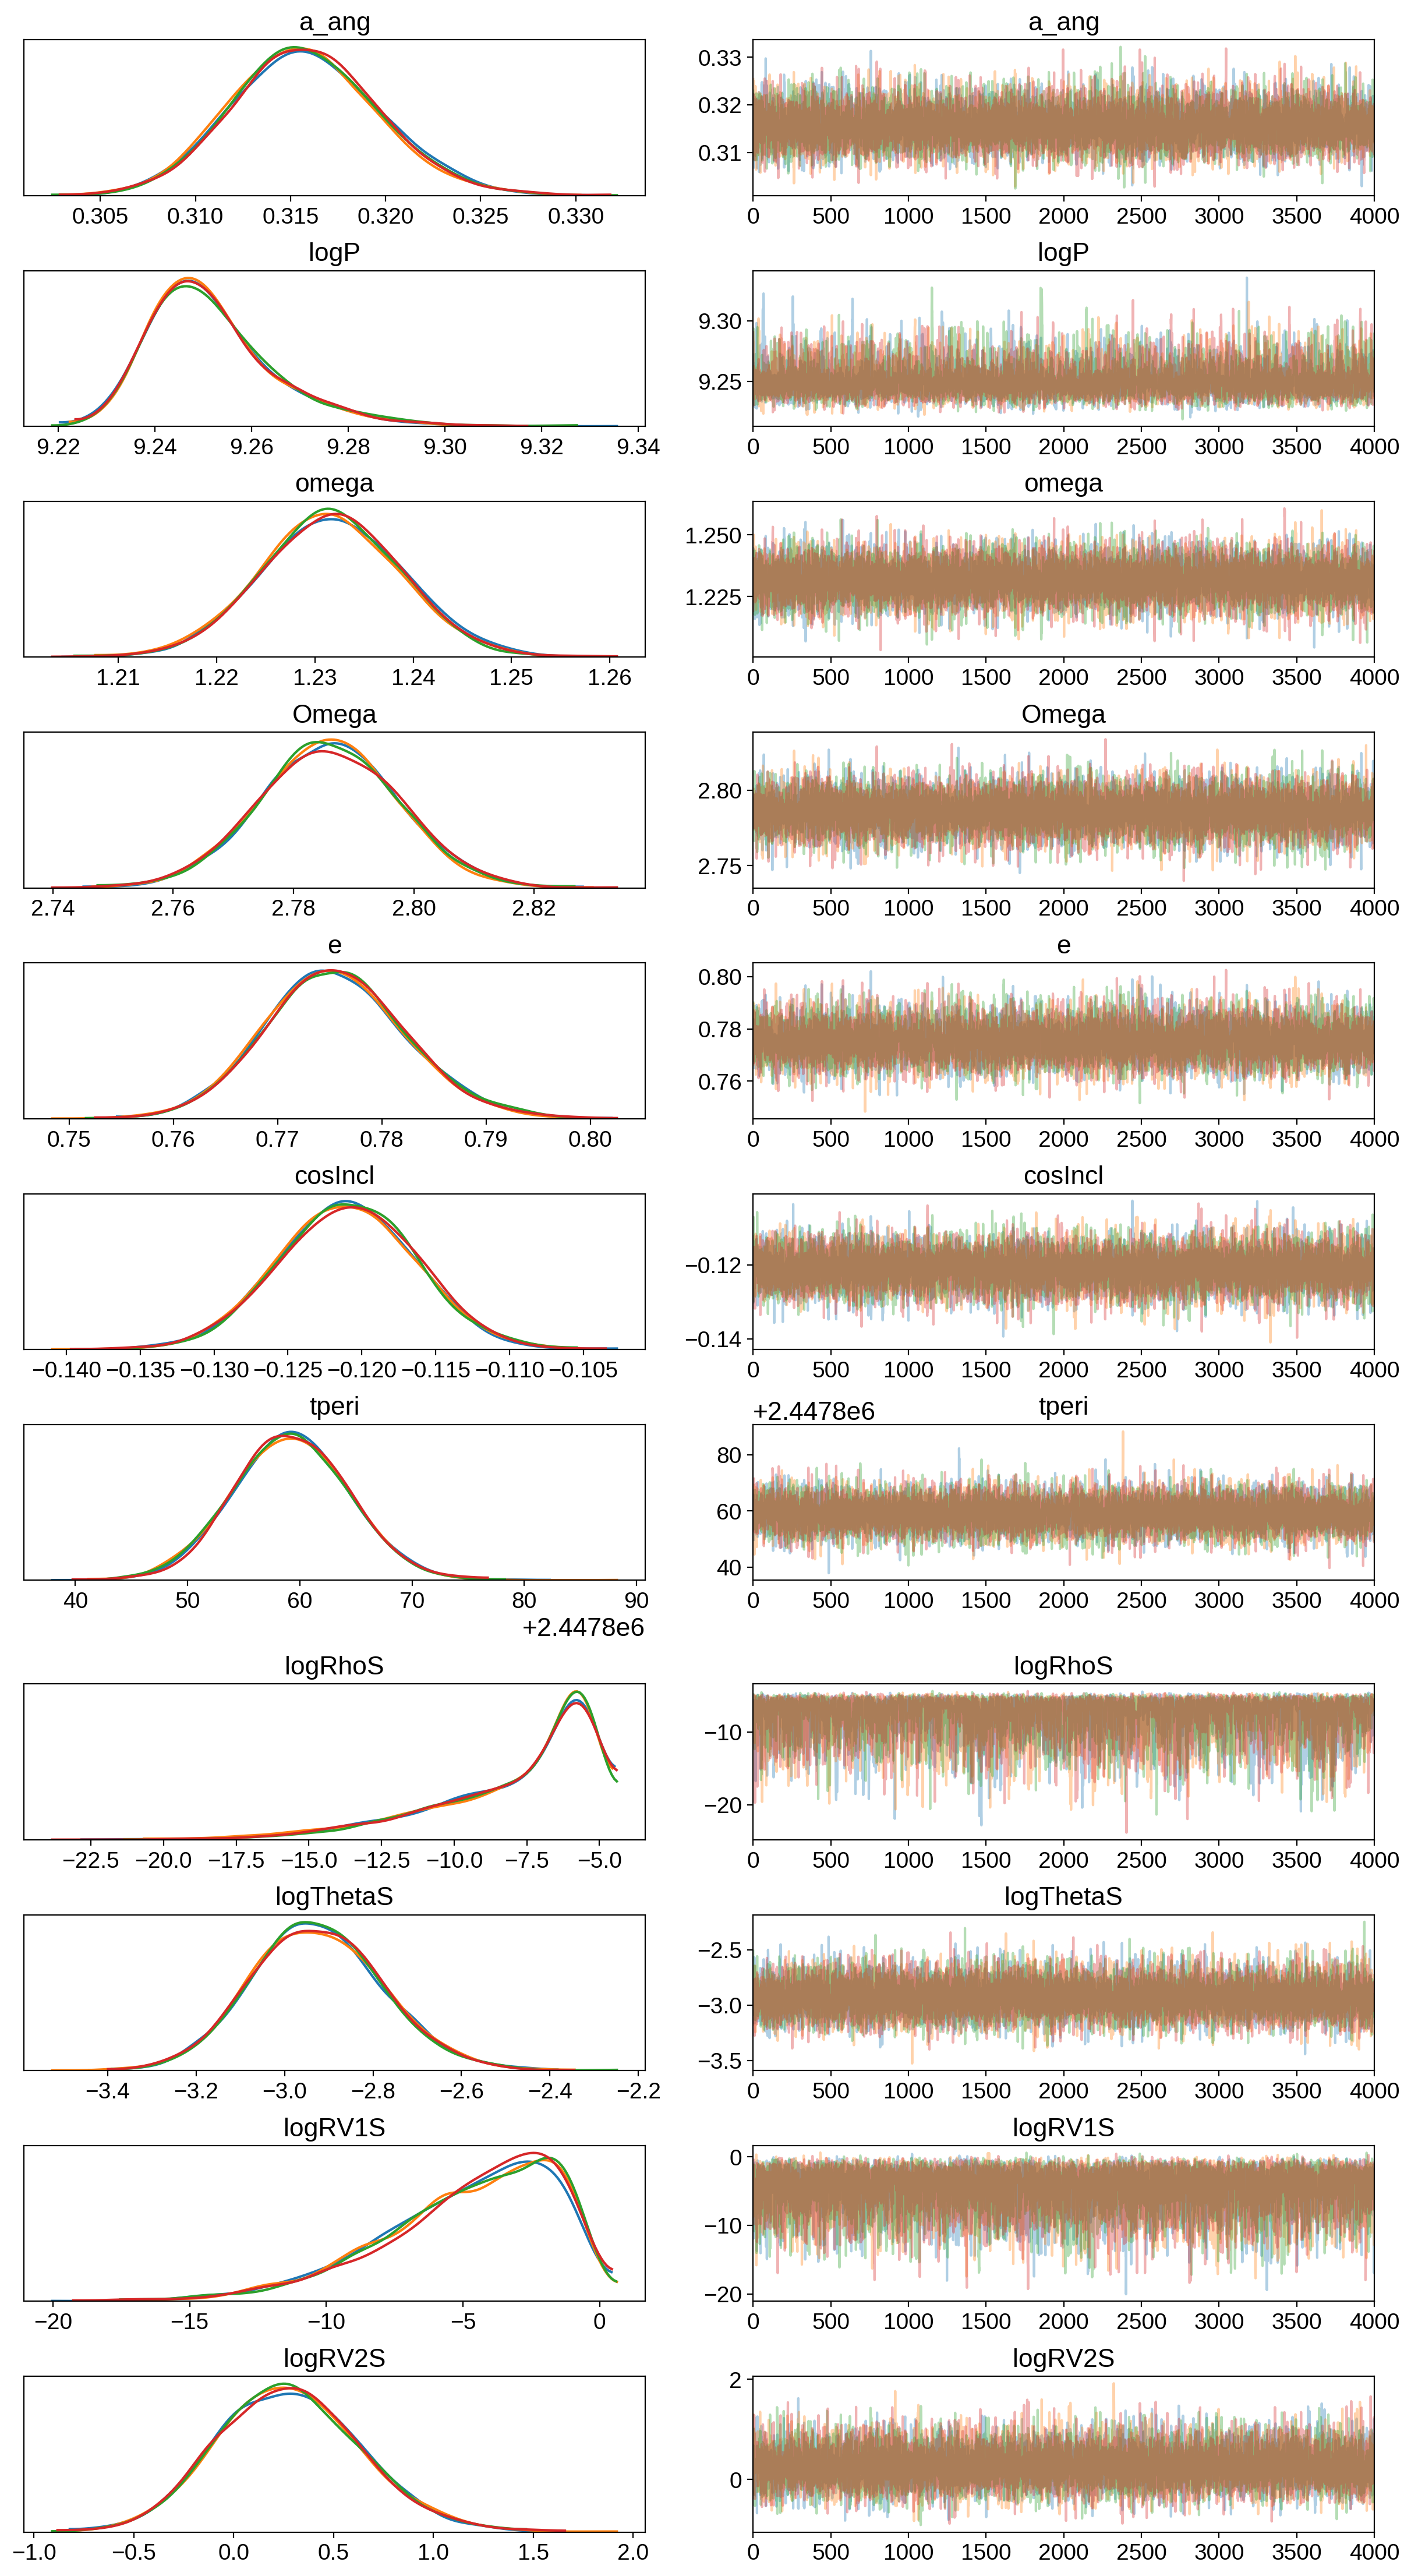

In [16]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

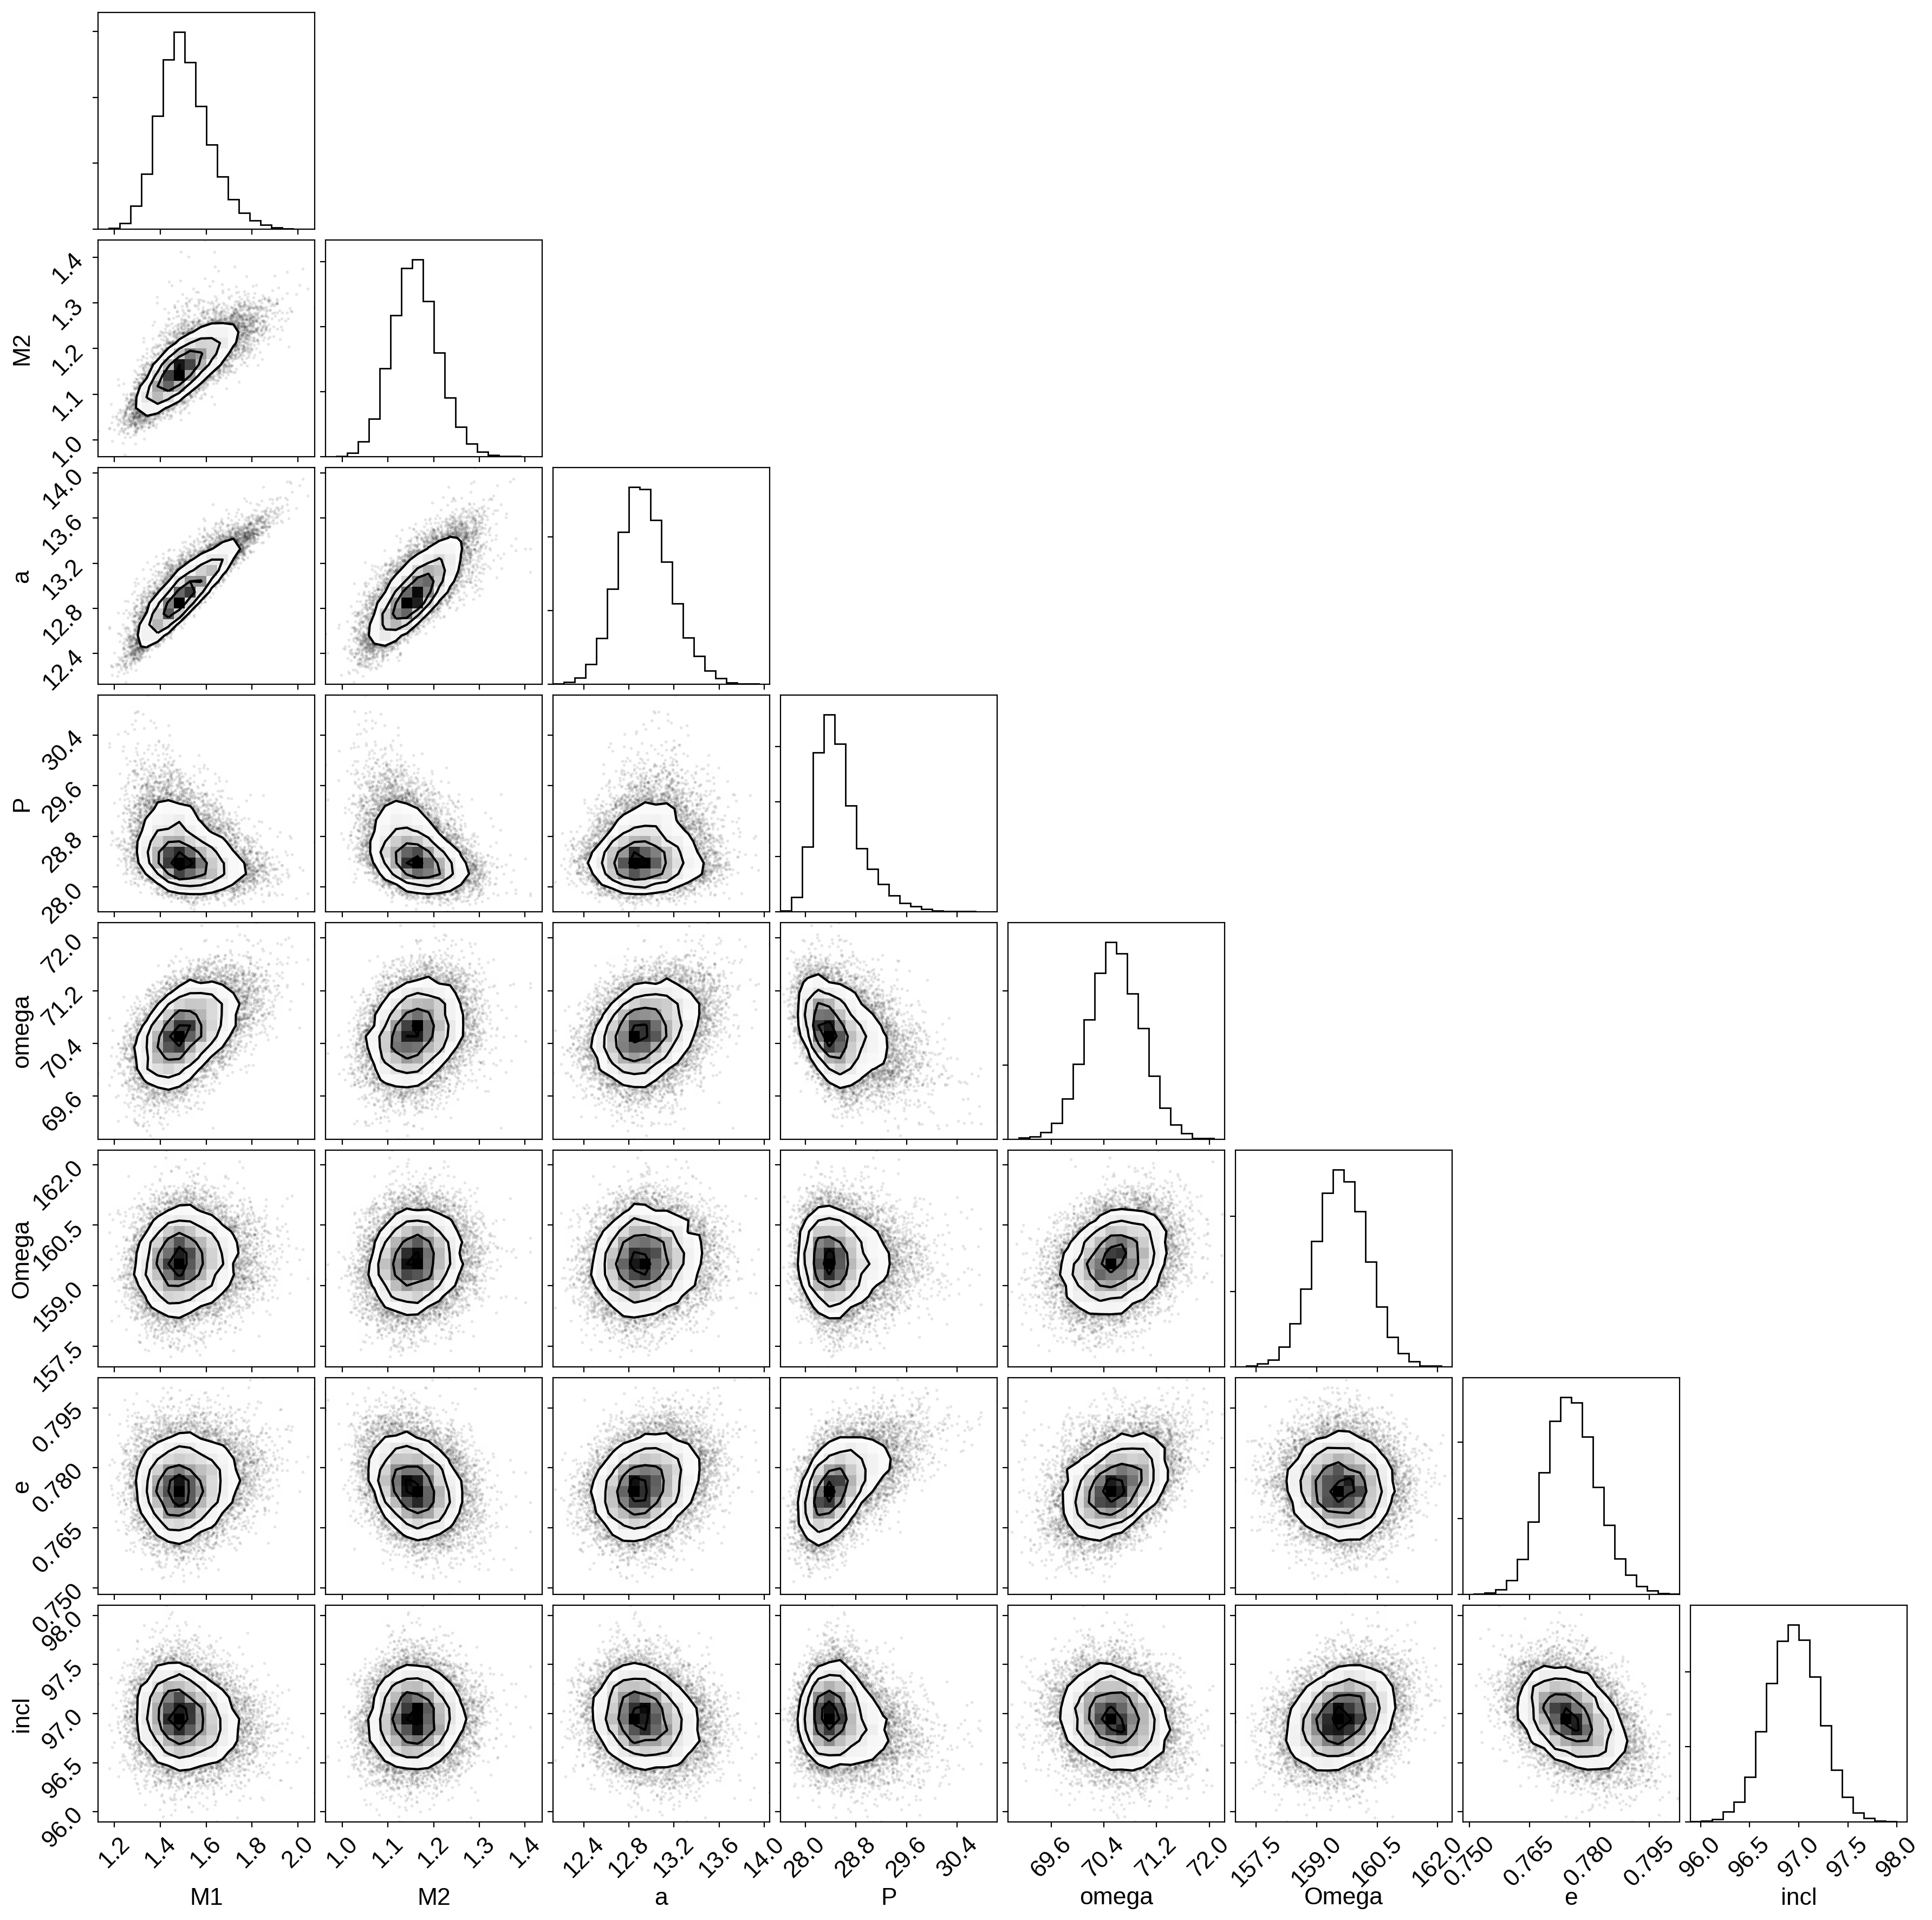

In [17]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["M1", "M2", "a", "P", "omega", "Omega", "e", "incl"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

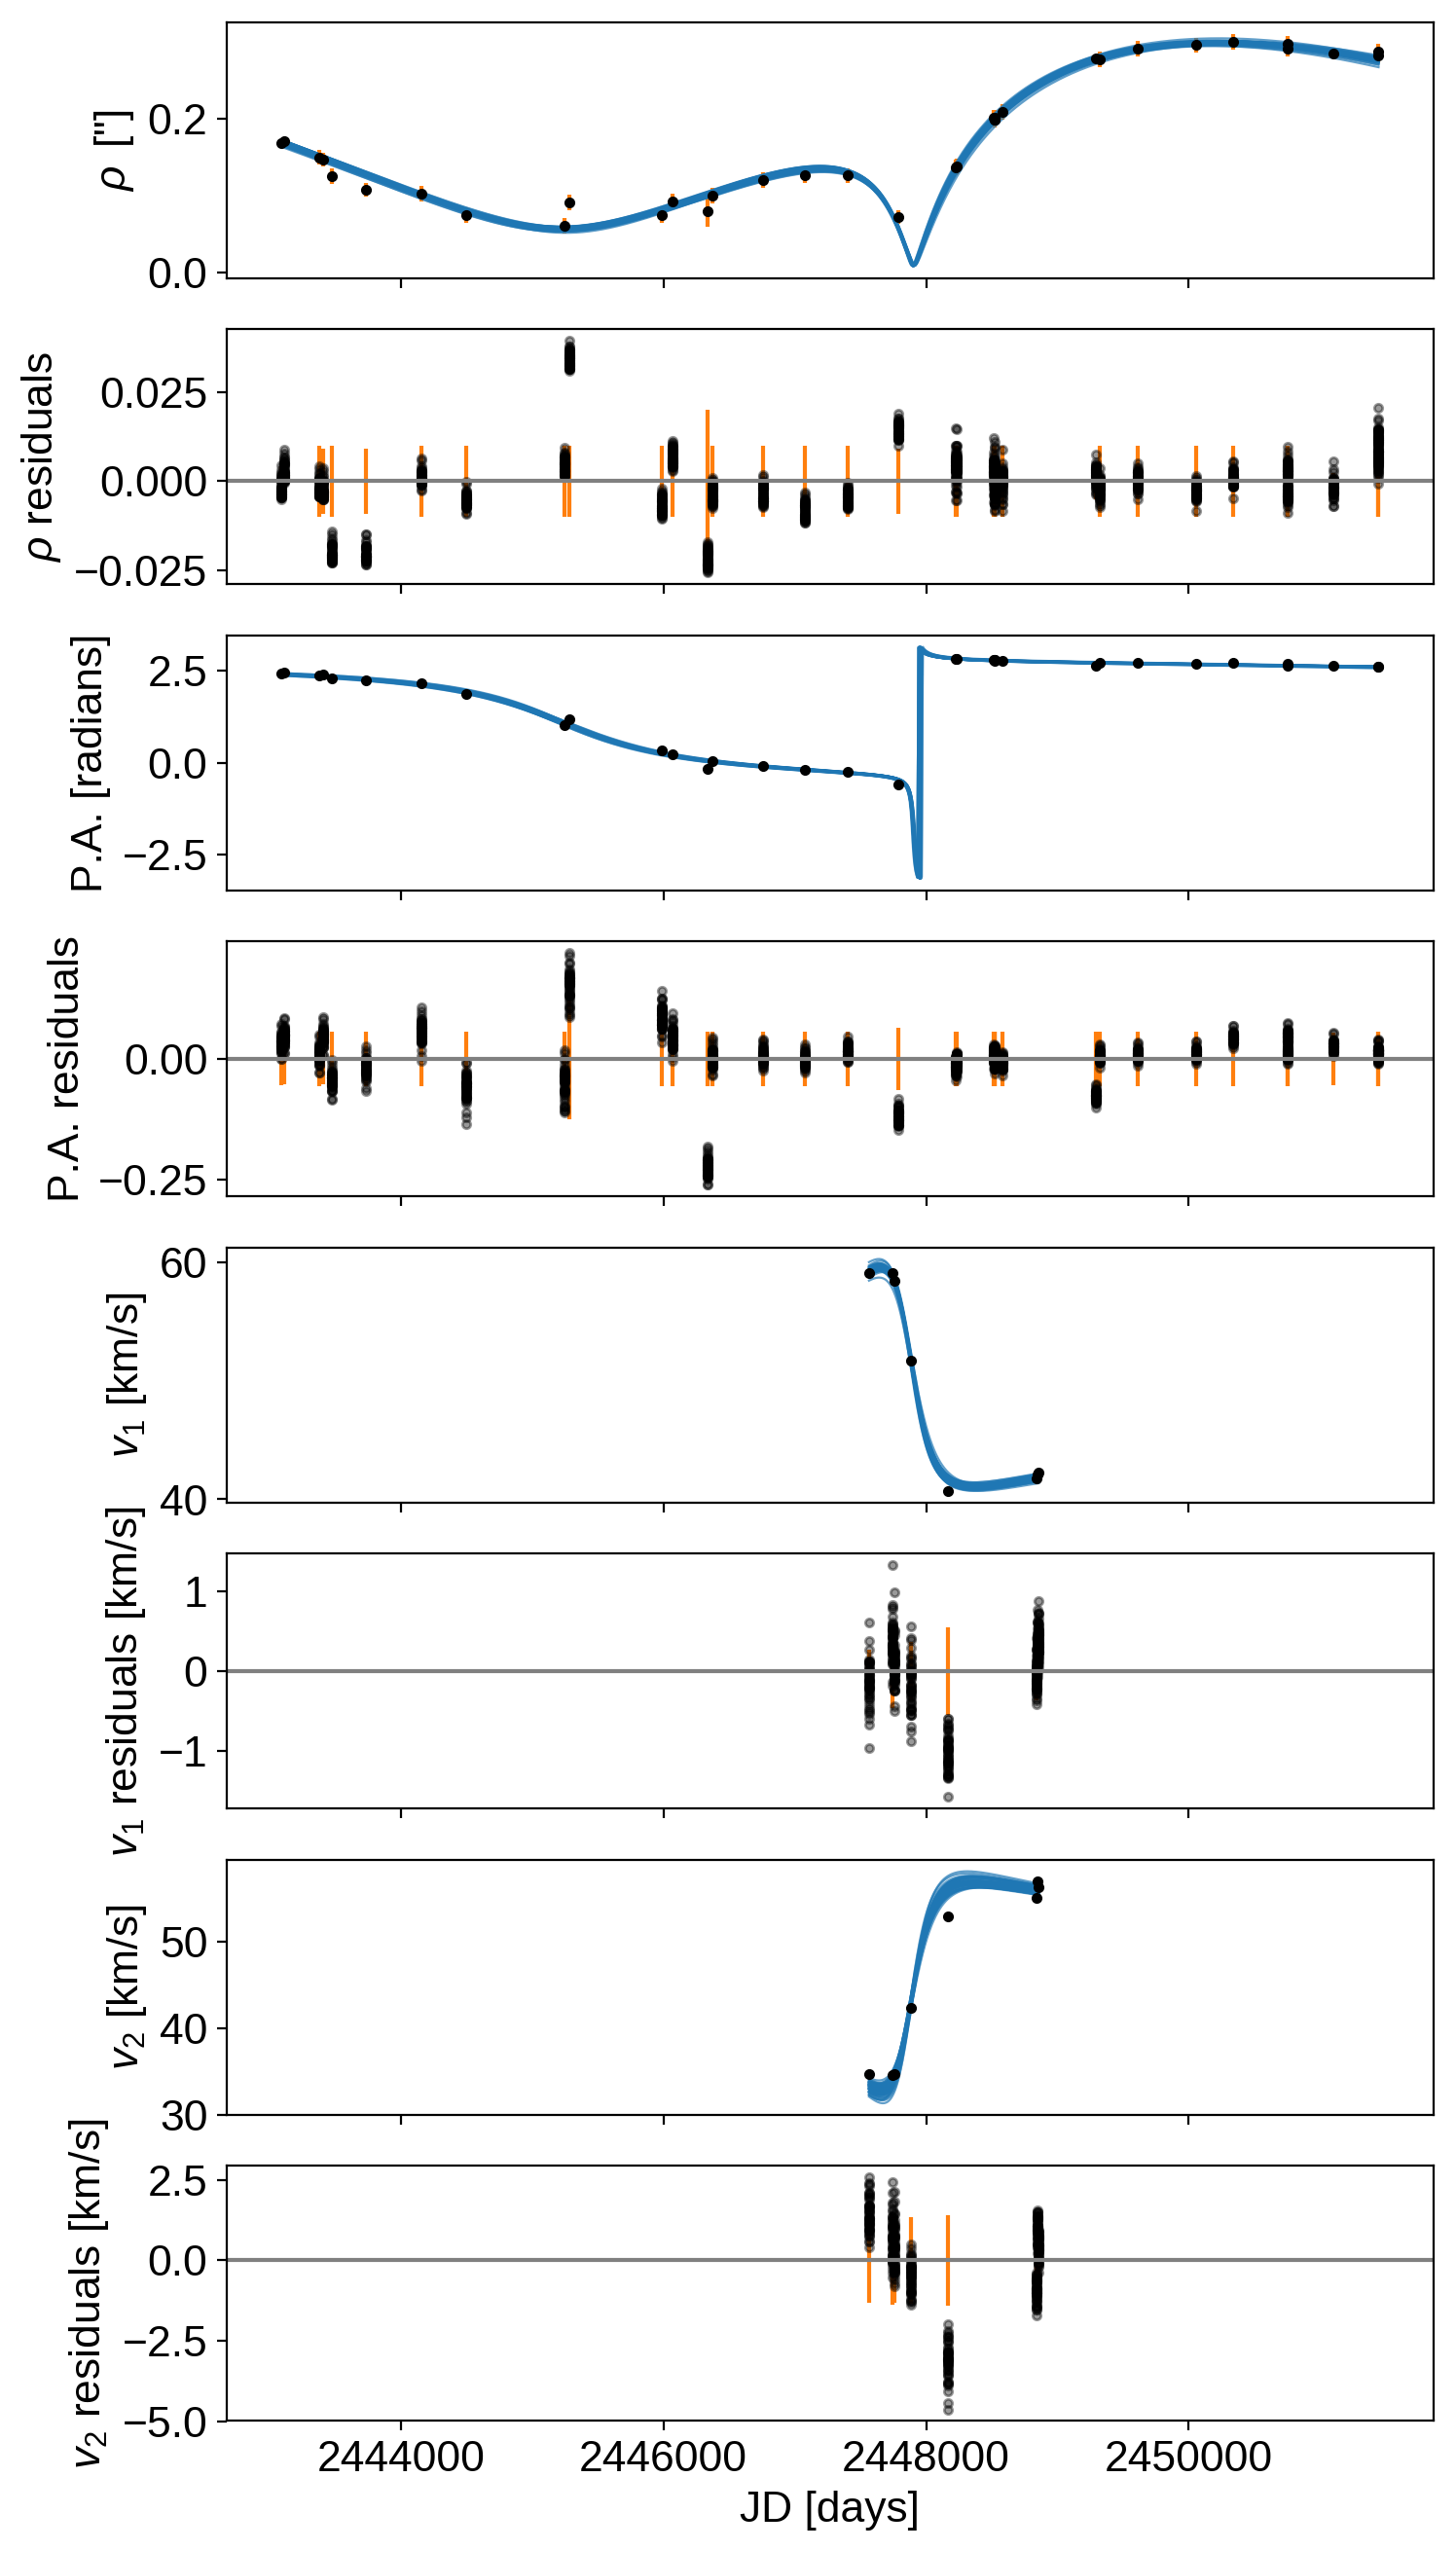

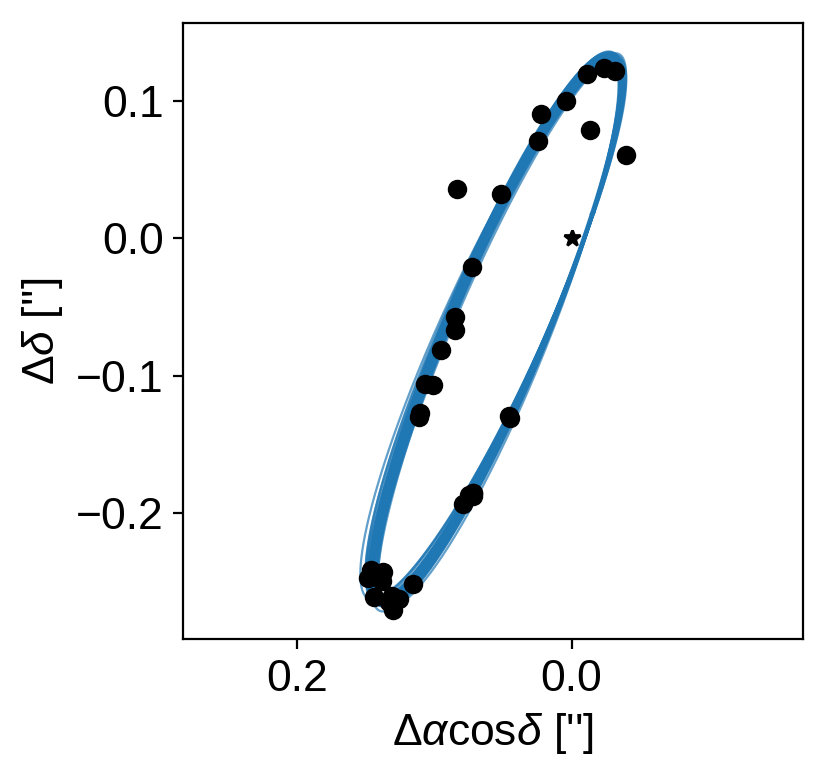

In [18]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(8,16))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)


xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")